# Computing GRNs for all timepoints in Zebrahub v1.0 using scRNA-seq

- We will use the Zebrahub v1.0 (scRNA-seq at 6 timepoints) to infer the cell-type, and timepoint specific GRNs.
- For the base GRN, we will use the zebrafish base GRN from CellOracle (based on CisBP, TSS database). This is to establish a baseline for how much we can learn from a static GRN (also, only accounting for proximal enhancers, without ATAC-seq).

- In the future steps, we can compare this with an improved version of GRNs (ATAC-seq, distal enhancers, and also time-resolved GRN).


Last updated: August 20th, 2023

# 0. Import libraries

In [1]:
# 0. Import

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
import celloracle as co
co.__version__

/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str

'0.14.0'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300


## 0.1. Check installation

Celloracle uses some R libraries in network analysis. 
Please make sure that all dependent R libraries are installed on your computer.
You can test the installation with the following command.

In [4]:
co.network_analysis.test_R_libraries_installation()

## 0.2. Make a folder to save graph

In [4]:
co_output_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/baseGRN_CisBP_RNA_zebrahub/"
save_folder = "figures"
os.makedirs(co_output_path + save_folder, exist_ok=True)

In [5]:
figpath = co_output_path + save_folder

# 1. Prepare data

In this notebook, we will use the zebrahub scRNA-seq data (in h5ad format).
Data preprocessing and annotation was done by Biohub, and the latest data object is stored in **/hpc/projects/data.science/alejandro/danio-atlas/zebrafish-atlas/ZF_atlas_v01.h5ad**



## 1.1. Load processed gene expression data (anndata)


In [6]:
! ls /hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/annotated_data/ZF_atlas_v01/

ZF_atlas_v01_15somite.h5Seurat	ZF_atlas_v01.h5Seurat
ZF_atlas_v01.h5ad		ZF_atlas_v01_integrated.h5ad
ZF_atlas_v01.h5seurat		ZF_atlas_v01_r_files


In [8]:
# # Load data. !!Replace the data path below when you use another data.
# filepath = "/hpc/projects/data.science/alejandro/danio-atlas/zebrahub_public_data/processed_objects/"

# os.listdir(filepath)

['zf_atlas_3dpf_v4_release.h5ad',
 'zf_atlas_14hpf_v4_release.h5ad',
 'zf_atlas_full_v4_release.h5ad',
 'zf_atlas_2dpf_v4_release.h5ad',
 'zf_atlas_5dpf_v4_release.h5ad',
 'zf_atlas_24hpf_v4_release.h5ad',
 'zf_atlas_10dpf_v4_release.h5ad',
 'zf_atlas_16hpf_v4_release.h5ad',
 'zf_atlas_12hpf_v4_release.h5ad',
 'zf_atlas_10hpf_v4_release.h5ad',
 'zf_atlas_19hpf_v4_release.h5ad']

In [18]:
# list_early_zebrahub_objects = ['zf_atlas_10hpf_v4_release.h5ad', # 0 budstage
#  'zf_atlas_12hpf_v4_release.h5ad', # 5 somites
#  'zf_atlas_14hpf_v4_release.h5ad', # 10 somite
#  'zf_atlas_16hpf_v4_release.h5ad', # 15 somites
#  'zf_atlas_19hpf_v4_release.h5ad', # 20 somites
#  'zf_atlas_24hpf_v4_release.h5ad'] # 30 somites
# list_early_zebrahub_objects

['zf_atlas_10hpf_v4_release.h5ad',
 'zf_atlas_12hpf_v4_release.h5ad',
 'zf_atlas_14hpf_v4_release.h5ad',
 'zf_atlas_16hpf_v4_release.h5ad',
 'zf_atlas_19hpf_v4_release.h5ad',
 'zf_atlas_24hpf_v4_release.h5ad']

In [37]:
# Load the zebrahub early timepoints
zebrahub = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/annotated_data/ZF_atlas_v01/ZF_atlas_v01.h5ad")
zebrahub

AnnData object with n_obs × n_vars = 38189 × 27877
    obs: 'n_genes', 'n_counts', '10X_run', 'fish', 'fish_n', 'timepoint', 'seqrun', 'log_ncounts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_nc', 'pct_counts_nc', 'cell_annotation', 'global_annotation'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'nc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'fish_colors', 'global_annotation_colors', 'hvg', 'neighbors', 'pca', 'timepoint_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [38]:
zebrahub.obs.value_counts("timepoint")

timepoint
30somite      14094
5somite        6699
15somite       6297
20somite       5905
10somite       3862
0 budstage     1332
dtype: int64

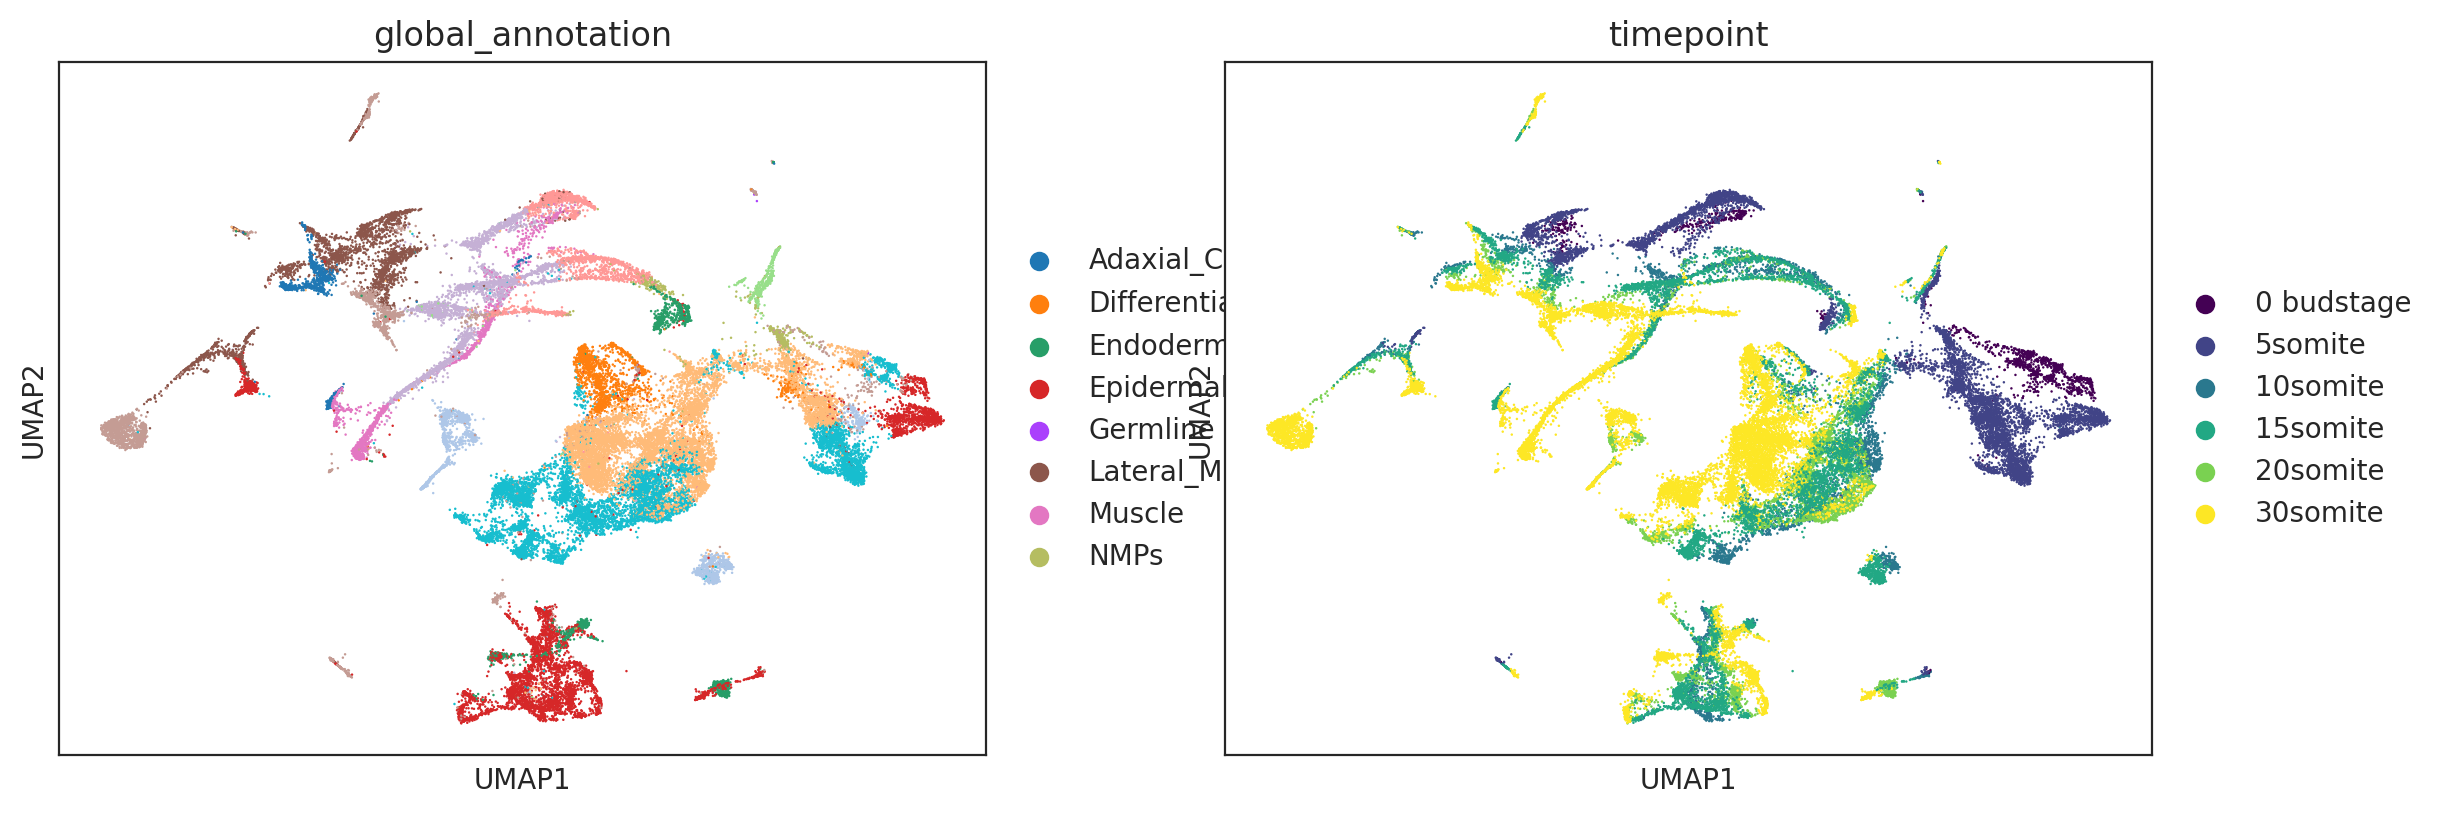

In [39]:
sc.pl.umap(zebrahub, color = ["global_annotation", "timepoint"])

In [40]:
zebrahub.X.todense()

matrix([[  0.,   0.,   1., ...,  62.,   0.,   0.],
        [  0.,   0.,   1., ...,  50.,   0.,   0.],
        [  0.,   0.,   1., ..., 154.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,  35.,   0.,   0.],
        [  0.,   0.,   0., ...,  33.,   0.,   0.],
        [  0.,   0.,   1., ...,  93.,   0.,   0.]], dtype=float32)

# !! CHECK scRNA-seq DATA !!

For the celloracle network analysis and simulation, scRNA-seq data format should meet some requirements. If you followed our tutorial notebook for the preprocessing of scRNA-seq data, the processed scRNA-seq data already should meet this requirements.

However if you made your scRNA-seq data in another method such as Seurat pipeline, please check your scRNA-seq data to make sure your scRNA-seq data meets celloracle's requiments below.

In [32]:
zebrahub.obs.value_counts("timepoint")

timepoint
30somite      14094
5somite        6699
15somite       6297
20somite       5905
10somite       3862
0 budstage     1332
dtype: int64

In [11]:
# zebrahub_integrated.obs.value_counts("timepoint")

timepoint
5dpf     24987
3dpf     22473
10dpf    20579
2dpf     15483
24hpf    12914
12hpf     6699
16hpf     6297
19hpf     5899
14hpf     3862
10hpf     1251
dtype: int64

In [41]:
# Check data shape

print("Number of cell : ", zebrahub.shape[0])
print("Number of gene : ", zebrahub.shape[1])

Number of cell :  38189
Number of gene :  27877


In [42]:
"tbxta" in zebrahub.var_names

True

## 1. Check gene expression value type

Celloracle input should be non-negative values WITHOUT log transformation and scaling.

You need to get your scRNA-seq data back into raw gene expression data.

In [47]:
# # In this notebook, we use raw mRNA count as an input of Oracle object.
# adata.X = adata.layers["raw_count"].copy()

## 2. Gene selection: Number of genes should be ~3000 or lower.

Gene selection should be done in the scRNA-seq gene expression matrix.
If your scRNA-seq still contains a lot of genes more than 3000, please do gene selection now.

In a general seurat analysis, highly variable genes are picked up and stored in your scRNA-seq data.
Please remove genes that are not in the variable gene list.

In [43]:
# compute the highly variable genes to reduce the number of gene feature space (RNA feature space)
sc.pp.highly_variable_genes(zebrahub, n_top_genes=3000, flavor="seurat_v3")
zebrahub_hvg = zebrahub[:,zebrahub.var.highly_variable]
zebrahub_hvg

View of AnnData object with n_obs × n_vars = 38189 × 3000
    obs: 'n_genes', 'n_counts', '10X_run', 'fish', 'fish_n', 'timepoint', 'seqrun', 'log_ncounts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_nc', 'pct_counts_nc', 'cell_annotation', 'global_annotation'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'nc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: 'fish_colors', 'global_annotation_colors', 'hvg', 'neighbors', 'pca', 'timepoint_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## 3. [Optional step] Downsampling cells if you have too many cells

Calculation time and memory can be too long / large if you have too many cells.
We recommend downsampling your data if you have scRNA-seq dasta with more than 20k cells.

In [29]:
# # Random down sampling
# random_sampling_size = 20000
# if adata.shape[0] > random_sampling_size:
#     cells_random = np.random.choice(adata.obs.index.values, random_sampling_size, replace=False)
    
#     adata = adata[cells_random, :]

In [31]:
# # Check data shape again

# print("Number of cell : ", adata.shape[0])
# print("Number of gene : ", adata.shape[1])

Number of cell :  20000
Number of gene :  3000


## 4. Check dimensional reduction and clustering data
When you load a scRNA-seq data, please enter the name of clustering data and dimensional reduction data.
The clustering data should be stored in the attribute of "obs" in the anndata.
Dimensional reduction data is supposed to be stored in the attribute of "obsm" in the anndata.
You can check these data by the following command.

If you are not familiar with anndata, please look at the documentation of annata (https://anndata.readthedocs.io/en/stable/) or Scanpy (https://scanpy.readthedocs.io/en/stable/).

For the celloracle analysis, the anndata shoud include the following:
- (1) gene expression count, 
- (2) clustering information, 
- (3) trajectory (dimensional reduction embeddings) data. 

In [44]:
# show meta data name in anndata
print("metadata columns :", list(zebrahub_hvg.obs.columns))

metadata columns : ['n_genes', 'n_counts', '10X_run', 'fish', 'fish_n', 'timepoint', 'seqrun', 'log_ncounts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_nc', 'pct_counts_nc', 'cell_annotation', 'global_annotation']


In [45]:
# The annotation class - "global_annotation"
zebrahub_hvg.obs.global_annotation.unique()

['Epidermal', 'Neural_Posterior', 'Neural_Anterior', 'Lateral_Mesoderm', 'PSM', ..., 'unassigned', 'Notochord', 'Endoderm', 'Germline', 'Adaxial_Cells']
Length: 15
Categories (15, object): ['Adaxial_Cells', 'Differentiating_Neurons', 'Endoderm', 'Epidermal', ..., 'Notochord', 'PSM', 'Somites', 'unassigned']

In [46]:
# Please select name of clustering data

clustering = "global_annotation"

# Check 
clustering in zebrahub_hvg.obs.columns

True

In [47]:
# Show dimensional reduction data in anndata
print("dimensional reduction: ", list(zebrahub_hvg.obsm.keys()))

dimensional reduction:  ['X_pca', 'X_umap']


In [48]:
# Please select name of dimensional reduction data
embedding = "X_umap"

### !! Important: Please check your clustering and dimensional reduction by visualizing them

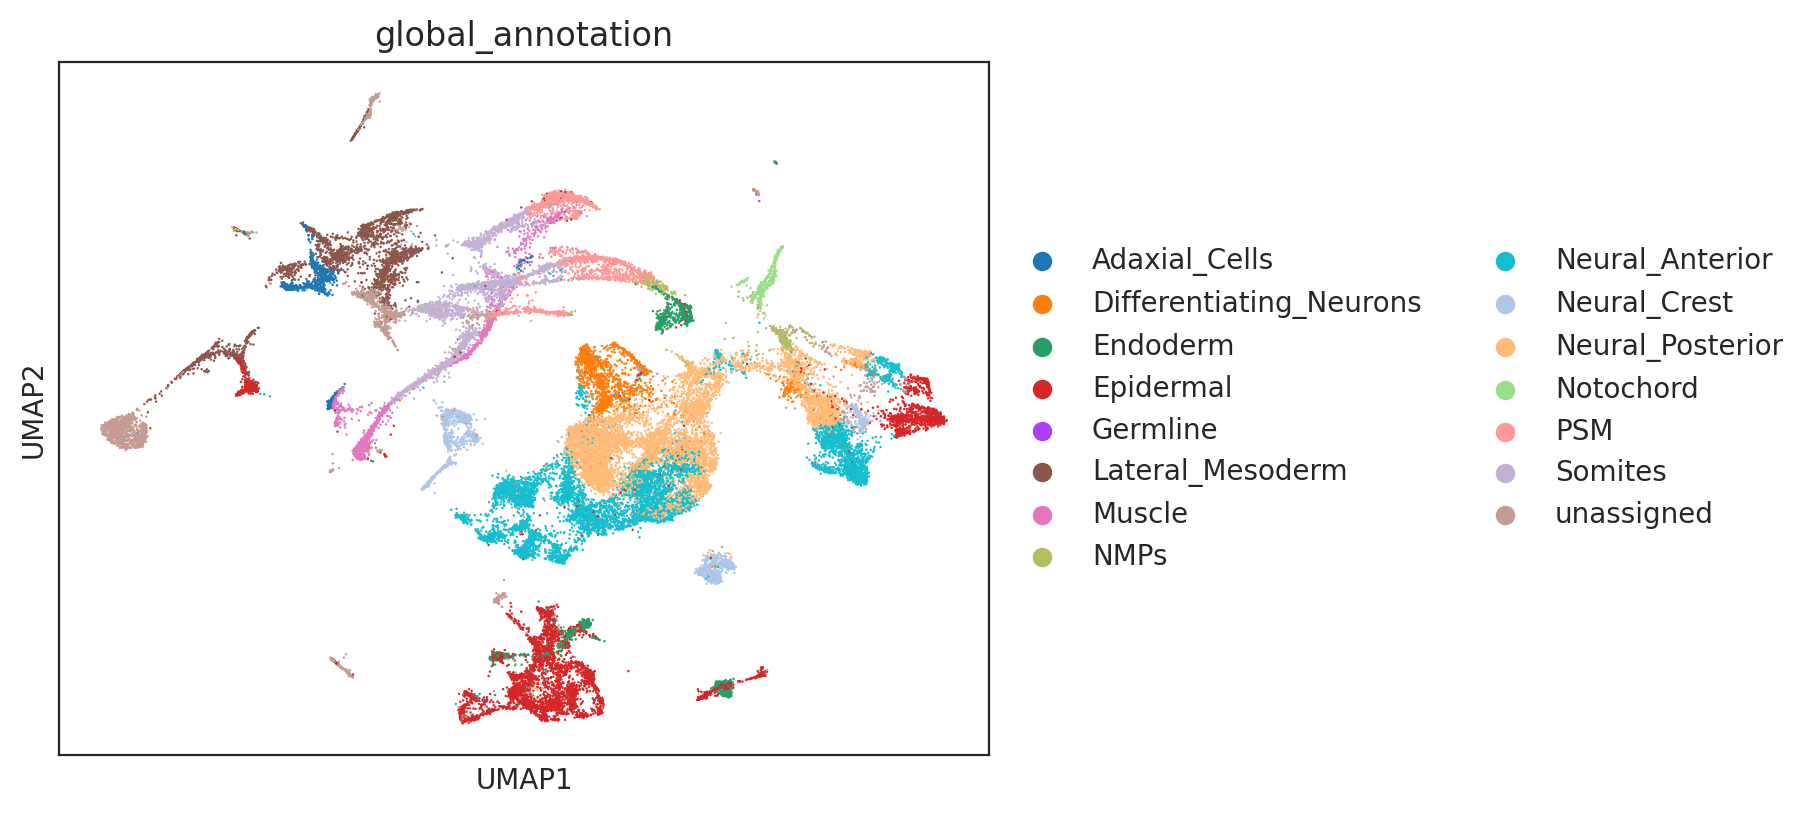

In [49]:
# Visualize
if embedding == "X_draw_graph_fa":
    sc.pl.draw_graph(zebrahub_hvg, color=clustering)

elif embedding == "X_umap":
    sc.pl.umap(zebrahub_hvg, color=clustering)
    
elif embedding == "X_tsne":
    sc.pl.tsne(zebrahub_hvg, color=clustering)

## 1.2. Load TF data. 
For the GRN inference, celloracle needs TF information, which contains lists of the regulatory candidate genes. 
There are several ways to make such TF information. We can generate TF information from scATAC-seq data or bulk ATAC-seq data. Please refer to the first step of the tutorial for the details of this process.


If you do not have your scATAC-seq data, you can use some built-in data in celloracle. The built-in TFinfo wqs made using various tissue/cell-types from the mouse ATAC-seq atlas dataset (http://atlas.gs.washington.edu/mouse-atac/).

You can load and use the data with the following command. 

## A static base GRN from zebrafish TSS/promoter info in CisBP

- This is the GRN used in CellOracle.
- Note that this GRN only accounted for proximal enhancers (TSS/promoter).

In [51]:
# Just to check, we loaded the zebrafish_promoter_based_GRN
TFinfo_df_zebrafish_promoter_based_GRN = co.data.load_zebrafish_promoter_base_GRN()
TFinfo_df_zebrafish_promoter_based_GRN

Loading prebuilt promoter base-GRN. Version: danRer11_CisBPv2_fpr2


peak_id gene_short_name  A6H8I1_DANRE  \
0           chr10_10312024_10313124            urm1           0.0   
1           chr10_10329454_10330554        mir219-1           0.0   
2           chr10_10385573_10386673           sardh           0.0   
3           chr10_10607018_10608118             dbh           0.0   
4           chr10_10727977_10729077            swi5           0.0   
...                             ...             ...           ...   
17775    chrUn_KZ116019v1_8579_9679            klc2           1.0   
17776    chrUn_KZ116023v1_2574_3674      zgc:153137           0.0   
17777  chrUn_KZ116034v1_31715_32815           cd247           0.0   
17778    chrUn_KZ116034v1_9585_9601         pou2f1a           0.0   
17779   chrUn_KZ116034v1_9602_10702         pou2f1a           0.0   

       CABZ01017151.1  CABZ01056727.1  CABZ01057488.2  CABZ01066696.1  \
0                 0.0             1.0             0.0             0.0   
1                 0.0             1.0             0.0             0.0   
2                 0.0             0.0             0.0             0.0   
3                 0.0             0.0             1.0             0.0   
4                 0.0             1.0             1.0             0.0   
...               ...             ...             ...             ...   
17775             0.0             1.0             1.0             0.0   
17776             0.0             0.0             0.0             0.0   
17777             0.0             0.0             1.0             0.0   
17778             0.0             0.0             0.0             0.0   
17779             0.0             1.0             0.0             0.0   

       CABZ01067175.1  CABZ01079847.1  CABZ01081359.1  ...  znf143b  znf148  \
0                 1.0             0.0             0.0  ...      0.0     0.0   
1                 1.0             0.0             0.0  ...      0.0     0.0   
2                 1.0             0.0             0.0  ...      0.0     0.0   
3                 0.0             0.0             0.0  ...      0.0     0.0   
4                 1.0             0.0             0.0  ...      0.0     0.0   
...               ...             ...             ...  ...      ...     ...   
17775             0.0             1.0             0.0  ...      1.0     0.0   
17776             1.0             0.0             0.0  ...      0.0     0.0   
17777             1.0             0.0             0.0  ...      0.0     0.0   
17778             0.0             0.0             0.0  ...      0.0     0.0   
17779             0.0             0.0             0.0  ...      0.0     0.0   

       znf281a  znf281b  znf652  znf653  znf711  znf740b  znf76  zzz3  
0          0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  
1          0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  
2          0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  
3          0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  
4          0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  
...        ...      ...     ...     ...     ...      ...    ...   ...  
17775      0.0      0.0     0.0     0.0     0.0      0.0    1.0   1.0  
17776      0.0      0.0     0.0     0.0     1.0      0.0    0.0   0.0  
17777      0.0      0.0     0.0     0.0     0.0      1.0    0.0   0.0  
17778      0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  
17779      0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  

[17780 rows x 869 columns]

In [52]:
print("tbxta" in TFinfo_df_zebrafish_promoter_based_GRN["gene_short_name"])
print("tbxta" in TFinfo_df_zebrafish_promoter_based_GRN.columns)

False
False


### NOTE

Keep in mind that we're missing some genes here as we only keep the genes with TSS/promoter annotation.

# 2. Initiate Oracle object

Celloracle has a custom called Oracle. We can use Oracle for the data preprocessing and GRN inference steps.
The Oracle object stores all of necessary information and does the calculations with its internal functions.
We instantiate an Oracle object, then input the gene expression data (anndata) and a TFinfo into the Oracle object.


- Here, we will create Oracle object for each timepoint, compute cell-type specific GRNs for each timepoint. (Therefore, the GRN is a function of (1) timepoint, and (2) cell-type.)
- Save the resulting GRNs in the folder for future dissection.

In [53]:
# make sure that all gene names are in lower-case
zebrahub_hvg.var_names = zebrahub_hvg.var_names.str.lower()
zebrahub_hvg.var_names_make_unique()
zebrahub_hvg.var_names

# make the base GRN's gene_short_name as well as columns as lowercase
TFinfo_df_zebrafish_promoter_based_GRN["gene_short_name"] = TFinfo_df_zebrafish_promoter_based_GRN["gene_short_name"].str.lower()
TFinfo_df_zebrafish_promoter_based_GRN.columns = TFinfo_df_zebrafish_promoter_based_GRN.columns.str.lower()
TFinfo_df_zebrafish_promoter_based_GRN

peak_id gene_short_name  a6h8i1_danre  \
0           chr10_10312024_10313124            urm1           0.0   
1           chr10_10329454_10330554        mir219-1           0.0   
2           chr10_10385573_10386673           sardh           0.0   
3           chr10_10607018_10608118             dbh           0.0   
4           chr10_10727977_10729077            swi5           0.0   
...                             ...             ...           ...   
17775    chrUn_KZ116019v1_8579_9679            klc2           1.0   
17776    chrUn_KZ116023v1_2574_3674      zgc:153137           0.0   
17777  chrUn_KZ116034v1_31715_32815           cd247           0.0   
17778    chrUn_KZ116034v1_9585_9601         pou2f1a           0.0   
17779   chrUn_KZ116034v1_9602_10702         pou2f1a           0.0   

       cabz01017151.1  cabz01056727.1  cabz01057488.2  cabz01066696.1  \
0                 0.0             1.0             0.0             0.0   
1                 0.0             1.0             0.0             0.0   
2                 0.0             0.0             0.0             0.0   
3                 0.0             0.0             1.0             0.0   
4                 0.0             1.0             1.0             0.0   
...               ...             ...             ...             ...   
17775             0.0             1.0             1.0             0.0   
17776             0.0             0.0             0.0             0.0   
17777             0.0             0.0             1.0             0.0   
17778             0.0             0.0             0.0             0.0   
17779             0.0             1.0             0.0             0.0   

       cabz01067175.1  cabz01079847.1  cabz01081359.1  ...  znf143b  znf148  \
0                 1.0             0.0             0.0  ...      0.0     0.0   
1                 1.0             0.0             0.0  ...      0.0     0.0   
2                 1.0             0.0             0.0  ...      0.0     0.0   
3                 0.0             0.0             0.0  ...      0.0     0.0   
4                 1.0             0.0             0.0  ...      0.0     0.0   
...               ...             ...             ...  ...      ...     ...   
17775             0.0             1.0             0.0  ...      1.0     0.0   
17776             1.0             0.0             0.0  ...      0.0     0.0   
17777             1.0             0.0             0.0  ...      0.0     0.0   
17778             0.0             0.0             0.0  ...      0.0     0.0   
17779             0.0             0.0             0.0  ...      0.0     0.0   

       znf281a  znf281b  znf652  znf653  znf711  znf740b  znf76  zzz3  
0          0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  
1          0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  
2          0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  
3          0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  
4          0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  
...        ...      ...     ...     ...     ...      ...    ...   ...  
17775      0.0      0.0     0.0     0.0     0.0      0.0    1.0   1.0  
17776      0.0      0.0     0.0     0.0     1.0      0.0    0.0   0.0  
17777      0.0      0.0     0.0     0.0     0.0      1.0    0.0   0.0  
17778      0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  
17779      0.0      0.0     0.0     0.0     0.0      0.0    0.0   0.0  

[17780 rows x 869 columns]

47
cell number is :3862
Auto-selected k is :96
41
cell number is :1332
Auto-selected k is :33
44
cell number is :5905
Auto-selected k is :147
42
cell number is :14094
Auto-selected k is :352
44
cell number is :6699
Auto-selected k is :167
49
cell number is :6297
Auto-selected k is :157


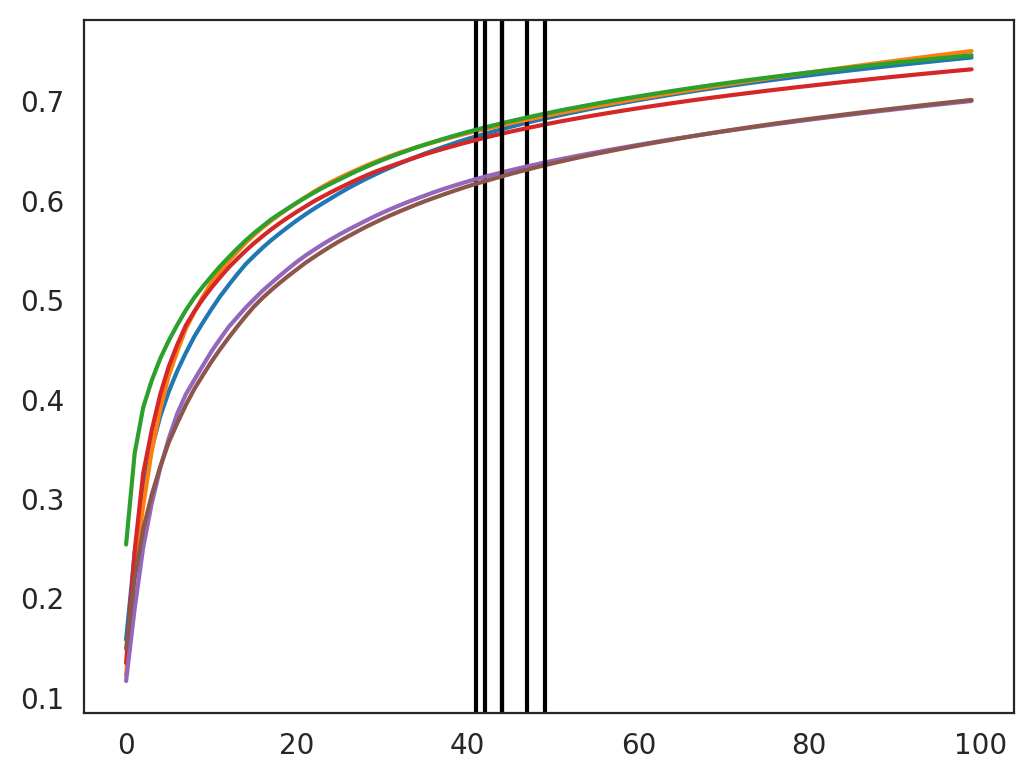

In [54]:
# filepath for the output Oracle objects
output_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/baseGRN_CisBP_RNA_zebrahub/"

# all timepoints
timepoints = zebrahub_hvg.obs.timepoint.unique().to_list()
timepoints

for stage in timepoints:
    # Instantiate Oracle object
    oracle = co.Oracle()
    
    # subset the anndata for one timepoint
    adata_subset = zebrahub_hvg[zebrahub_hvg.obs.timepoint==stage]
    
    # Step 1. Add the scRNA-seq (adata) to the Oracle object
    oracle.import_anndata_as_raw_count(adata=adata_subset,
                                       cluster_column_name="global_annotation",
                                       embedding_name="X_umap")
    
    # Step 2. Add the base GRN (TF info dataframe)
    oracle.import_TF_data(TF_info_matrix=TFinfo_df_zebrafish_promoter_based_GRN)
    
    # Step 3. KNN imputation
    # Perform PCA
    oracle.perform_PCA()

#     # Select important PCs
#     plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
#     n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
#     plt.axvline(n_comps, c="k")
#     print(n_comps)
#     n_comps = min(n_comps, 50)
    
    # number of cells
    n_cell = oracle.adata.shape[0]
    print(f"cell number is :{n_cell}")
    
    # number of k
    k = int(0.025*n_cell)
    print(f"Auto-selected k is :{k}")
    
    # KNN imputation
    oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                          b_maxl=k*4, n_jobs=4)

    # Save oracle object.output_filepath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/"
    oracle.to_hdf5(output_path + "06_"+ stage + ".celloracle.oracle")

# 3. GRN calculation
The next step is constructing a cluster-specific GRN for all clusters.

You can calculate  GRNs with the "get_links" function, and the function returns GRNs as a Links object.
The Links object stores inferred GRNs and the corresponding metadata. You can do network analysis with the Links object.

The GRN will be calculated for each cluster/sub-group.
In the example below, we construct GRN for each unit of the "louvain_annot" clustering.

The GRNs can be calculated at any arbitrary unit as long as the clustering information is stored in anndata.

In [40]:
# oracle = co.load_hdf5(output_path + "06_"+ stage + ".celloracle.oracle")
# oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.14.0
    n_cells: 6297
    n_genes: 3000
    cluster_name: global_annotation
    dimensional_reduction_name: X_umap
    n_target_genes_in_TFdict: 12674 genes
    n_regulatory_in_TFdict: 863 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 347 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1844 genes
    k_for_knn_imputation: 157
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

In [55]:
output_path

'/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/baseGRN_CisBP_RNA_zebrahub/'

In [56]:
%%time
for stage in timepoints:
    # Load the Oracle object for each timepoint
    oracle = co.load_hdf5(output_path + "06_"+ stage + ".celloracle.oracle")
    # print the info
    info = oracle._generate_meta_data()
    info

    #%%time
    # Calculate GRN for each population in "predicted.id" clustering unit.
    # This step may take long time (~ 1hour)
    links = oracle.get_links(cluster_name_for_GRN_unit="global_annotation", alpha=10,
                             verbose_level=10, test_mode=False, n_jobs=-1)
    
    # filter the GRN (2000 edges)
    links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
    
    # Calculate network scores. It takes several minutes.
    links.get_score(n_jobs=-1)
    
    # save the Links object (for all cell-types)
    links.to_hdf5(file_path=output_path + "08_"+ stage + "_celltype_GRNs.celloracle.links")
    
    # 2) cell-type specific GRNs - save for each cell-type
    # create a directory for each timepoint
    os.makedirs(output_path + "07_" + stage, exist_ok=True)
    GRN_output_path = output_path + "07_" + stage
    
    # save cell-type specific GRNs to the timepoint-specific directories
    for cluster in links.links_dict.keys():
        # Set cluster name
        cluster = cluster

        # Save as csv
        links.links_dict[cluster].to_csv(GRN_output_path + "/" + f"raw_GRN_for_{cluster}.csv")

  0%|          | 0/13 [00:00<?, ?it/s]

Inferring GRN for Differentiating_Neurons...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Endoderm...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Epidermal...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Lateral_Mesoderm...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Muscle...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for NMPs...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Neural_Anterior...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Neural_Crest...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Neural_Posterior...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Notochord...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for PSM...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Somites...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for unassigned...


  0%|          | 0/2202 [00:00<?, ?it/s]

R path: /hpc/apps/x86_64/r/4.2/bin/R



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



checking R library installation: igraph -> OK


Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: RColorBrewer

Welcome to linkcomm version 1.0-14

For a step-by-step guide to using linkcomm functions:
   > vignette(topic = "linkcomm", package = "linkcomm")
To run an interactive demo:
   > demo(topic = "linkcomm", package = "linkcomm")
To cite, see:
   > citation("linkcomm")
NOTE: To use linkcomm, you require read and write permissions in the current directory (see: help("getwd"), help("setwd"))



checking R library installation: linkcomm -> OK
checking R library installation: rnetcarto -> OK
processing... batch 1/1



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: RColorBrewer

Welcome to linkcomm version 1.0-14

For a step-by-step guide to using linkcomm functions:
   > vignette(topic = "linkcomm", package = "linkcomm")
To run an interactive demo:
   > demo(topic = "linkcomm", package = "linkcomm")
To cite, see:
   > citation("linkcomm")
NOTE: To use linkcomm, you require read and write permissions in the current directory (see: help("getwd"), help("setwd"))


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: RColorBrewer

Welcome to linkcomm version 1.0-14

For a step-by-step guide to using linkcomm functions:
   > vignette(topic = "linkcomm", package = "linkcomm")
To run an interactive demo:
   > d

Differentiating_Neurons: finished.
Endoderm: finished.


finished
finished
finished
finished


Epidermal: finished.
Lateral_Mesoderm: finished.
Muscle: finished.
NMPs: finished.
Neural_Anterior: finished.
Neural_Crest: finished.
Neural_Posterior: finished.
Notochord: finished.
PSM: finished.
Somites: finished.
unassigned: finished.


  0%|          | 0/14 [00:00<?, ?it/s]

Inferring GRN for Differentiating_Neurons...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Endoderm...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Epidermal...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Germline...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Lateral_Mesoderm...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Muscle...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for NMPs...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Neural_Anterior...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Neural_Crest...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Neural_Posterior...


  0%|          | 0/2202 [00:00<?, ?it/s]

Inferring GRN for Notochord...


  0%|          | 0/2202 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Inferring GRN for Lateral_Mesoderm...


  0%|          | 0/2202 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Inferring GRN for Neural_Anterior...


  0%|          | 0/2202 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



R path: /hpc/apps/x86_64/r/4.2/bin/R



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



checking R library installation: igraph -> OK


Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: RColorBrewer

Welcome to linkcomm version 1.0-14

For a step-by-step guide to using linkcomm functions:
   > vignette(topic = "linkcomm", package = "linkcomm")
To run an interactive demo:
   > demo(topic = "linkcomm", package = "linkcomm")
To cite, see:
   > citation("linkcomm")
NOTE: To use linkcomm, you require read and write permissions in the current directory (see: help("getwd"), help("setwd"))



checking R library installation: linkcomm -> OK
checking R library installation: rnetcarto -> OK
processing... batch 1/1



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: RColorBrewer

Welcome to linkcomm version 1.0-14

For a step-by-step guide to using linkcomm functions:
   > vignette(topic = "linkcomm", package = "linkcomm")
To run an interactive demo:
   > demo(topic = "linkcomm", package = "linkcomm")
To cite, see:
   > citation("linkcomm")
NOTE: To use linkcomm, you require read and write permissions in the current directory (see: help("getwd"), help("setwd"))


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: RColorBrewer

Welcome to linkcomm version 1.0-14

For a step-by-step guide to using linkcomm functions:
   > vignette(topic = "linkcomm", package = "linkcomm")
To run an interactive demo:
   > d

Differentiating_Neurons: finished.


finished


Endoderm: finished.


finished
finished


Epidermal: finished.


finished


Lateral_Mesoderm: finished.
Muscle: finished.
NMPs: finished.
Neural_Anterior: finished.
Neural_Crest: finished.
Neural_Posterior: finished.
Notochord: finished.
PSM: finished.
Somites: finished.
unassigned: finished.


  0%|          | 0/13 [00:00<?, ?it/s]

Inferring GRN for Adaxial_Cells...


  0%|          | 0/2202 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Inferring GRN for Epidermal...


  0%|          | 0/2202 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Inferring GRN for Neural_Anterior...


  0%|          | 0/2202 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



R path: /hpc/apps/x86_64/r/4.2/bin/R



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



checking R library installation: igraph -> OK


Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: RColorBrewer

Welcome to linkcomm version 1.0-14

For a step-by-step guide to using linkcomm functions:
   > vignette(topic = "linkcomm", package = "linkcomm")
To run an interactive demo:
   > demo(topic = "linkcomm", package = "linkcomm")
To cite, see:
   > citation("linkcomm")
NOTE: To use linkcomm, you require read and write permissions in the current directory (see: help("getwd"), help("setwd"))



checking R library installation: linkcomm -> OK
checking R library installation: rnetcarto -> OK
processing... batch 1/1



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: RColorBrewer

Welcome to linkcomm version 1.0-14

For a step-by-step guide to using linkcomm functions:
   > vignette(topic = "linkcomm", package = "linkcomm")
To run an interactive demo:
   > demo(topic = "linkcomm", package = "linkcomm")
To cite, see:
   > citation("linkcomm")
NOTE: To use linkcomm, you require read and write permissions in the current directory (see: help("getwd"), help("setwd"))


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: RColorBrewer

Welcome to linkcomm version 1.0-14

For a step-by-step guide to using linkcomm functions:
   > vignette(topic = "linkcomm", package = "linkcomm")
To run an interactive demo:
   > d

Adaxial_Cells: finished.


finished
finished
finished
finished


Differentiating_Neurons: finished.
Endoderm: finished.


finished
finished
finished
finished
finished


Epidermal: finished.
Muscle: finished.
NMPs: finished.
Neural_Anterior: finished.


finished


Neural_Crest: finished.
Neural_Posterior: finished.
Notochord: finished.
PSM: finished.
Somites: finished.
unassigned: finished.


  0%|          | 0/13 [00:00<?, ?it/s]

Inferring GRN for Differentiating_Neurons...


  0%|          | 0/2202 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Inferring GRN for Lateral_Mesoderm...


  0%|          | 0/2202 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Inferring GRN for Neural_Anterior...


  0%|          | 0/2202 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Inferring GRN for Notochord...


  0%|          | 0/2202 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Inferring GRN for Epidermal...


  0%|          | 0/2202 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Inferring GRN for NMPs...


  0%|          | 0/2202 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Inferring GRN for Somites...


  0%|          | 0/2202 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [57]:
info

{'celloracle version used for instantiation': '0.14.0',
 'n_cells': 6297,
 'n_genes': 3000,
 'status - Gene expression matrix': 'Ready',
 'cluster_name': 'global_annotation',
 'dimensional_reduction_name': 'X_umap',
 'n_target_genes_in_TFdict': '15296 genes',
 'n_regulatory_in_TFdict': '863 genes',
 'n_regulatory_in_both_TFdict_and_scRNA-seq': '347 genes',
 'n_target_genes_both_TFdict_and_scRNA-seq': '2202 genes',
 'status - BaseGRN': 'Ready',
 'status - PCA calculation': 'Done',
 'status - Knn imputation': 'Done',
 'k_for_knn_imputation': 157,
 'status - GRN calculation for simulation': 'Not finished'}

# ---------- DEPRECATED --------------

From the old notebook (CellOracle)

Now that we have computed the GRNs (cell-type, timepoint), we can start some EDA on the network scores, network properties, etc.

Some ideas are:
- network score across cell-types (at one timepoint - 15 somite?)
- network score across timepoints (for one cell-type)
- network score across timepoints/cell-type at individual gene level -> or use the dynamics of network scores (over time/cell-types) to screen the genes whose roles would change over time/cell-types.


Last updated: 08/21/2023

## 5.3. (Optional) Change order

The links object has a color information in an attribute, "palette".
This information is used for the visualization

The sample will be visualized in that order. 
Here we can change the order.

In [116]:
# # Show the contents of pallete
# links.palette

palette
Adaxial_Cells            #1F77B4
Differentiating_Neurons  #FF7F0E
Endoderm                 #279E68
Epidermal                #D62728
Lateral_Mesoderm         #AA40FC
Muscle                   #8C564B
NMPs                     #E377C2
Neural_Anterior          #B5BD61
Neural_Crest             #17BECF
Neural_Posterior         #AEC7E8
Notochord                #FFBB78
PSM                      #98DF8A
Somites                  #FF9896
unassigned               #C5B0D5

In [76]:
# # Change the order of pallete
# order = ['MEP_0', 'Mk_0','Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5',
#          'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9','GMP_0', 'GMP_1',
#          'GMPl_0', 'Mo_0', 'Mo_1', 'Gran_0', 'Gran_1', 'Gran_2']
# links.palette = links.palette.loc[order]
# links.palette

palette
MEP_0   #0FCFC0
Mk_0    #9CDED6
Ery_0   #7D87B9
Ery_1   #BEC1D4
Ery_2   #D6BCC0
Ery_3   #BB7784
Ery_4   #8E063B
Ery_5   #4A6FE3
Ery_6   #8595E1
Ery_7   #B5BBE3
Ery_8   #E6AFB9
Ery_9   #E07B91
GMP_0   #D33F6A
GMP_1   #11C638
GMPl_0  #8DD593
Mo_0    #D5EAE7
Mo_1    #F3E1EB
Gran_0  #C6DEC7
Gran_1  #EAD3C6
Gran_2  #F0B98D

# 6. Network preprocessing

## 6.1. Filter network edges 
Celloracle utilizes bagging ridge or Bayesian ridge regression to infer gene regulatory networks. 
These methods provide a network edge strength as a distribution rather than a point value. 
We can use the distribution to know the certainness of the connection.

We filter the network edges as follows.

 (1) Remove uncertain network edges based on the p-value.
 
 (2) Remove weak network edge. In this tutorial, we pick up the top 2000 edges in terms of network strength.


The raw network data is stored as an attribute, **"links_dict,"** while filtered network data is stored in **"filtered_links."** 
Thus the filtering function keeps raw network information rather than overwriting the data. You can come back to the filtering process to filter the data with different parameters if you want.

In [58]:
# %%time

# GRN_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/baseGRN_TDR118_RNA_zebrahub/"
# for stage in timepoints:
    
#     # import the Links object for each timepoint
#     links = co.load_hdf5(GRN_path + "08_" + stage + "_celltype_GRNs.celloracle.links")
    
#     # filter the GRN
#     links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
    
#     # Calculate network scores. It takes several minutes.
#     links.get_score(n_jobs=-1)
    
#     # plot the degree distribution (optional)
# #     links.plot_degree_distributions(plot_model=True, 
# #                                                #save=f"{save_folder}/degree_distribution/",
# #                                                )
    
#     # save the Links object with filtered GRN (and also the raw GRN)
#     links.to_hdf5(GRN_path + "08_"+ stage + "_celltype_GRNs.celloracle.links")
#     print(stage + " saved")

## 6.2. Degree distribution 
In the first step, we examine the network degree distribution.
Network degree, which is the number of edges for each node, is one of the important metrics used to investigate the network structure (https://en.wikipedia.org/wiki/Degree_distribution).

Please keep in mind that the degree distribution may change depending on the filtering threshold.

In [47]:
plt.rcParams["figure.figsize"] = [9, 4.5]

Adaxial_Cells


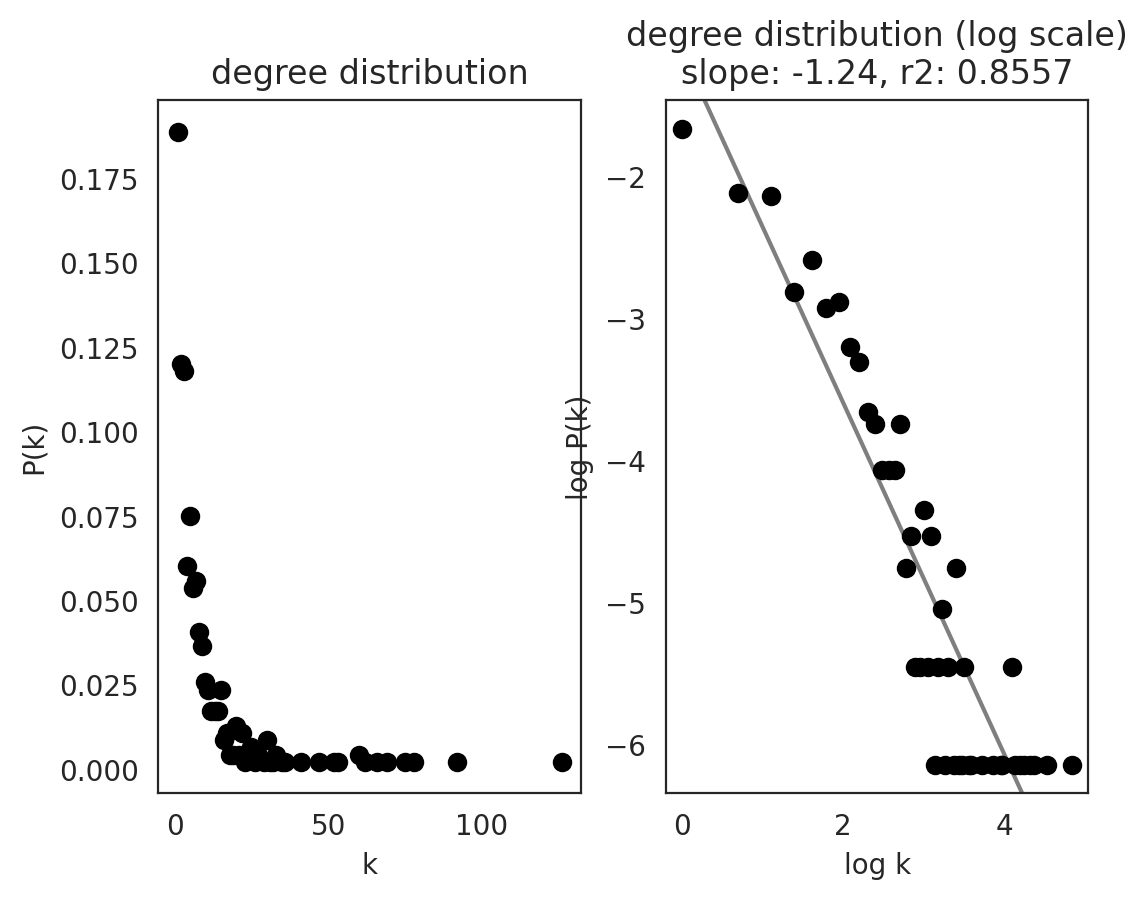

Differentiating_Neurons


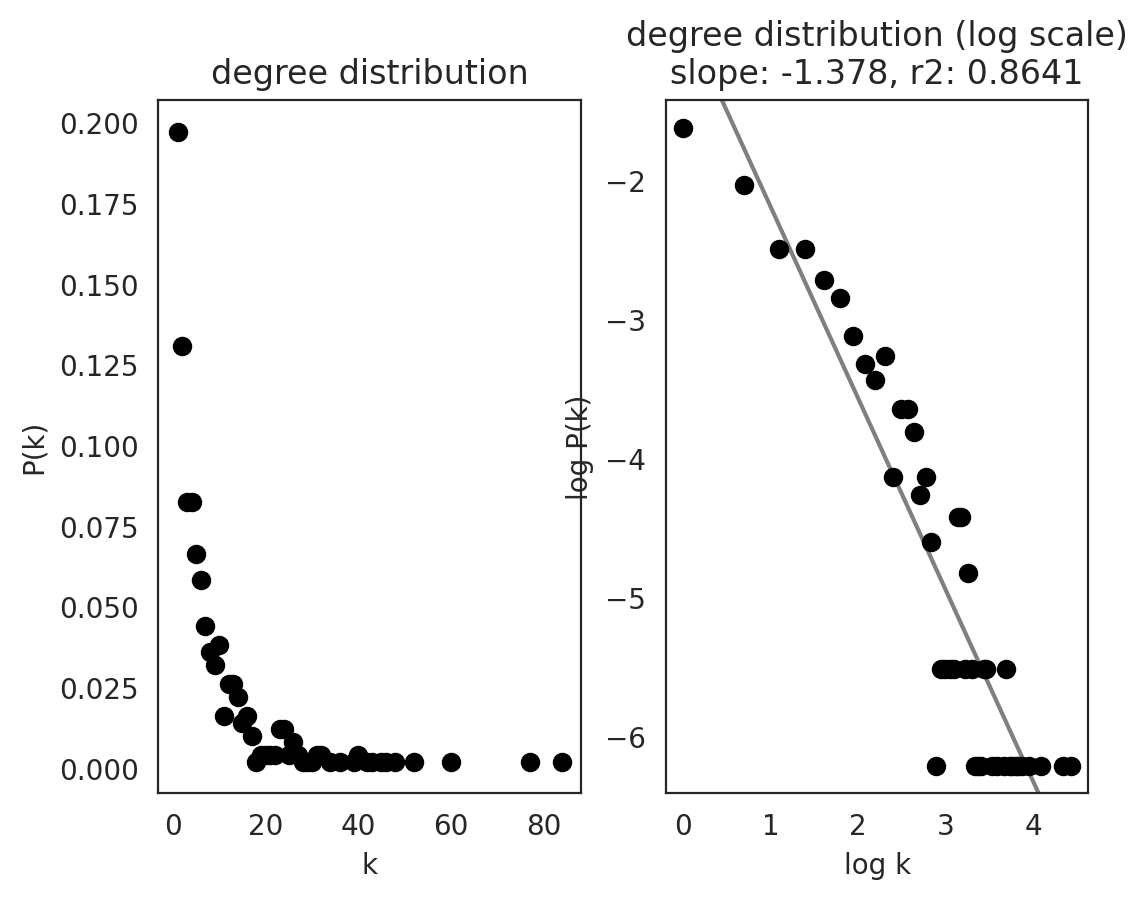

Endoderm


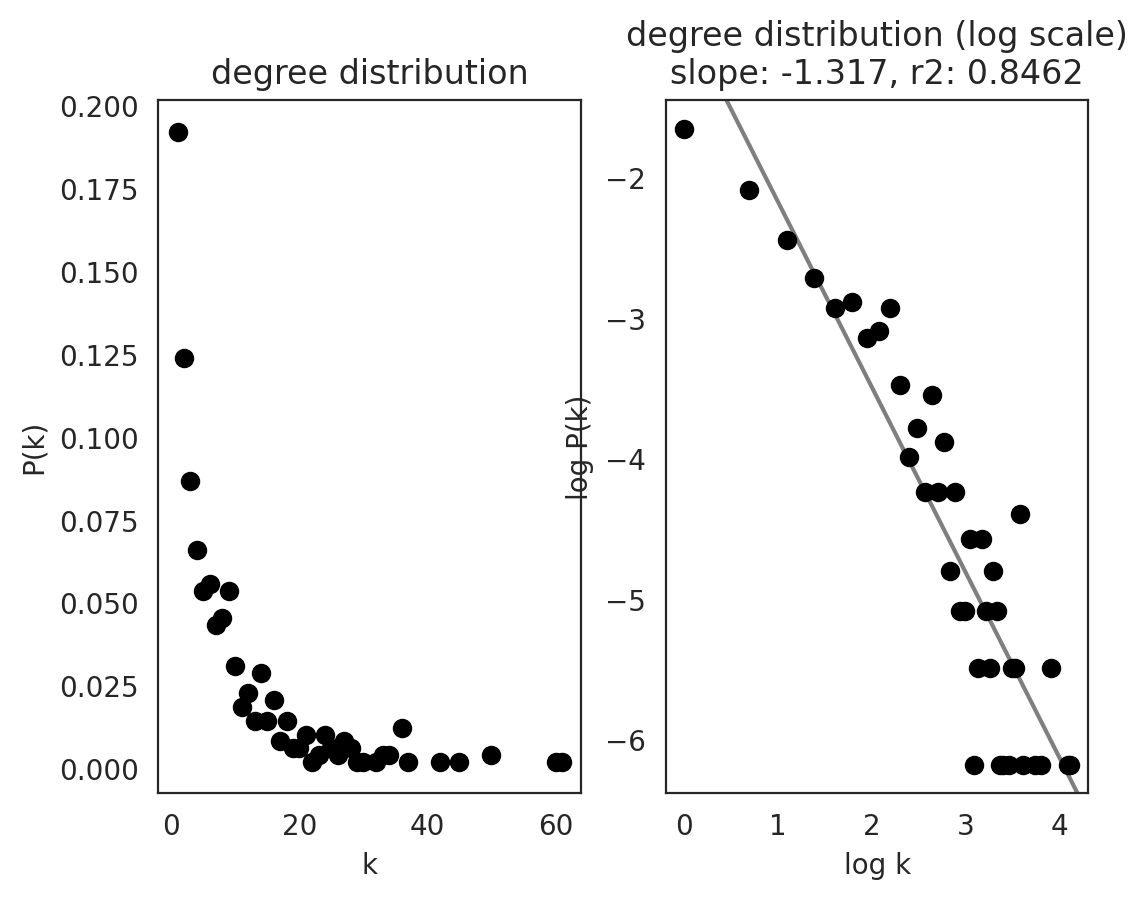

Epidermal


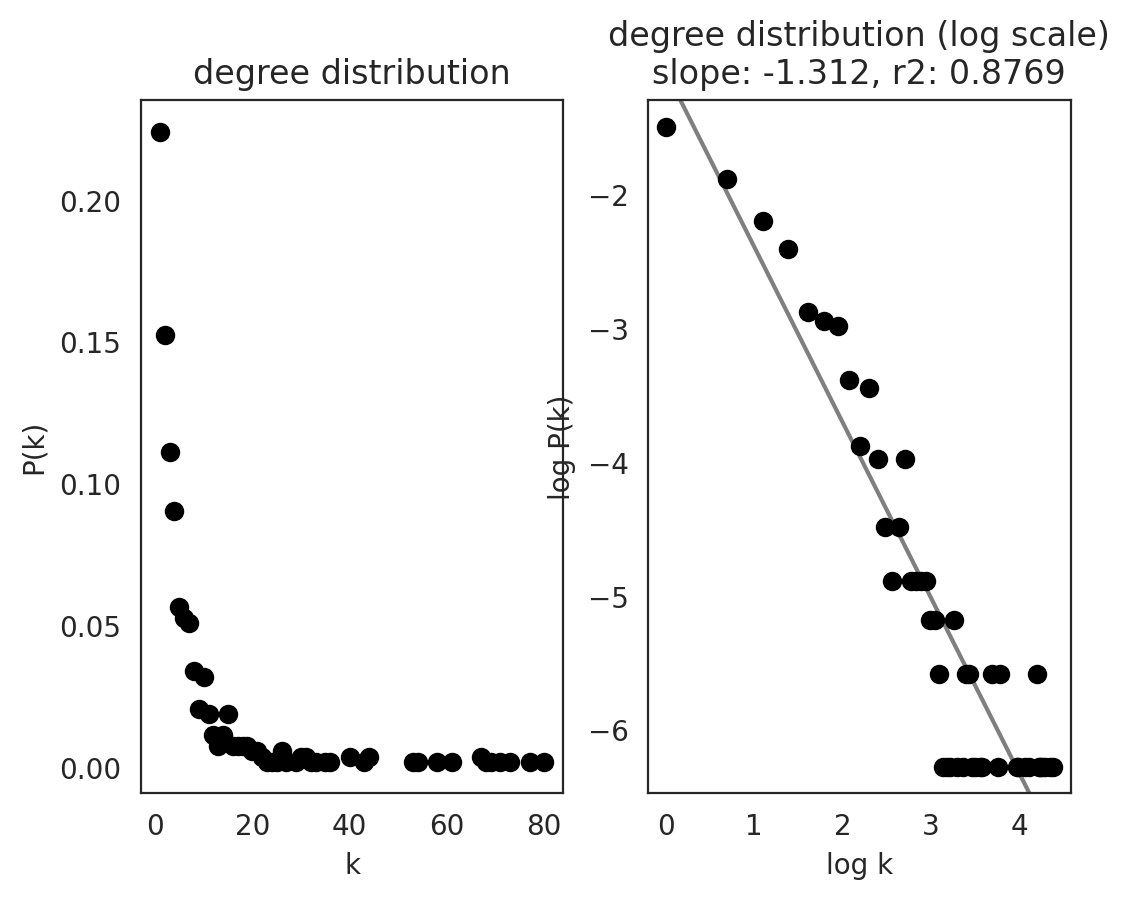

Lateral_Mesoderm


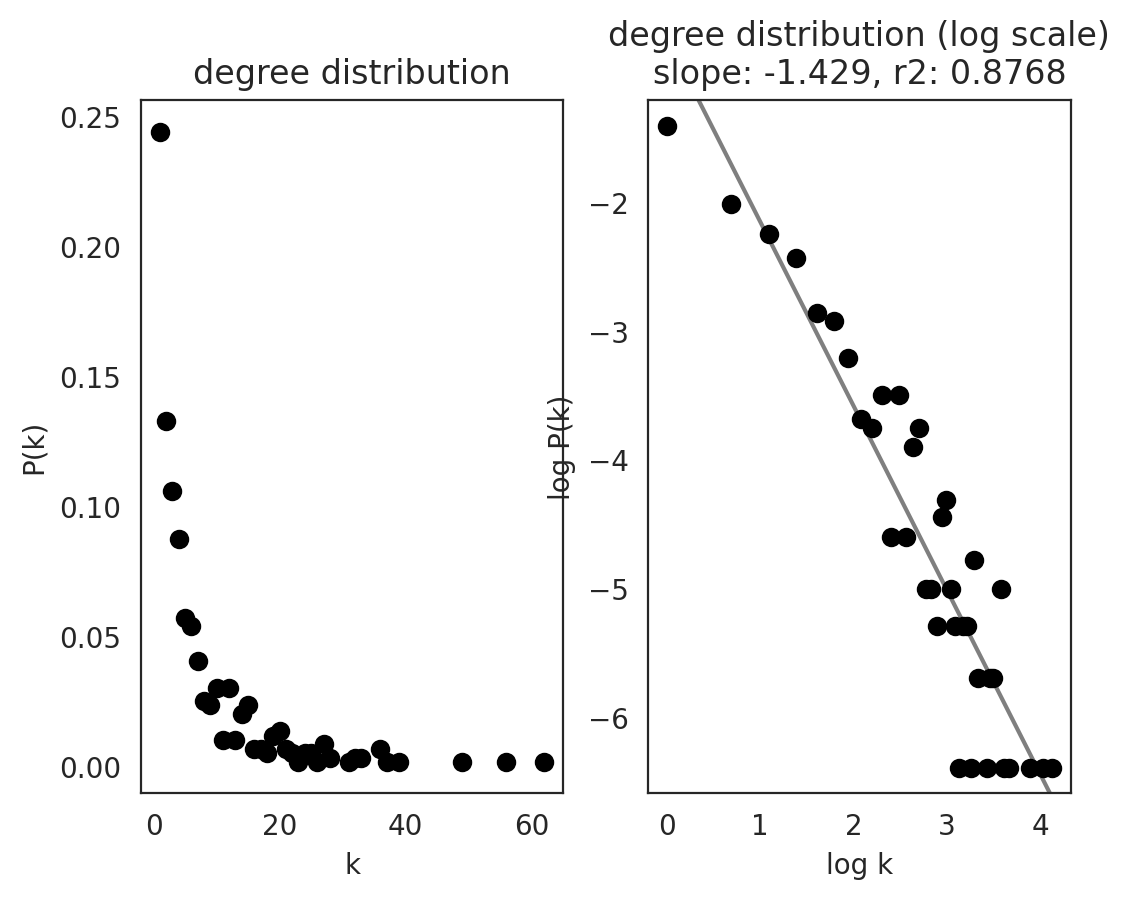

Muscle


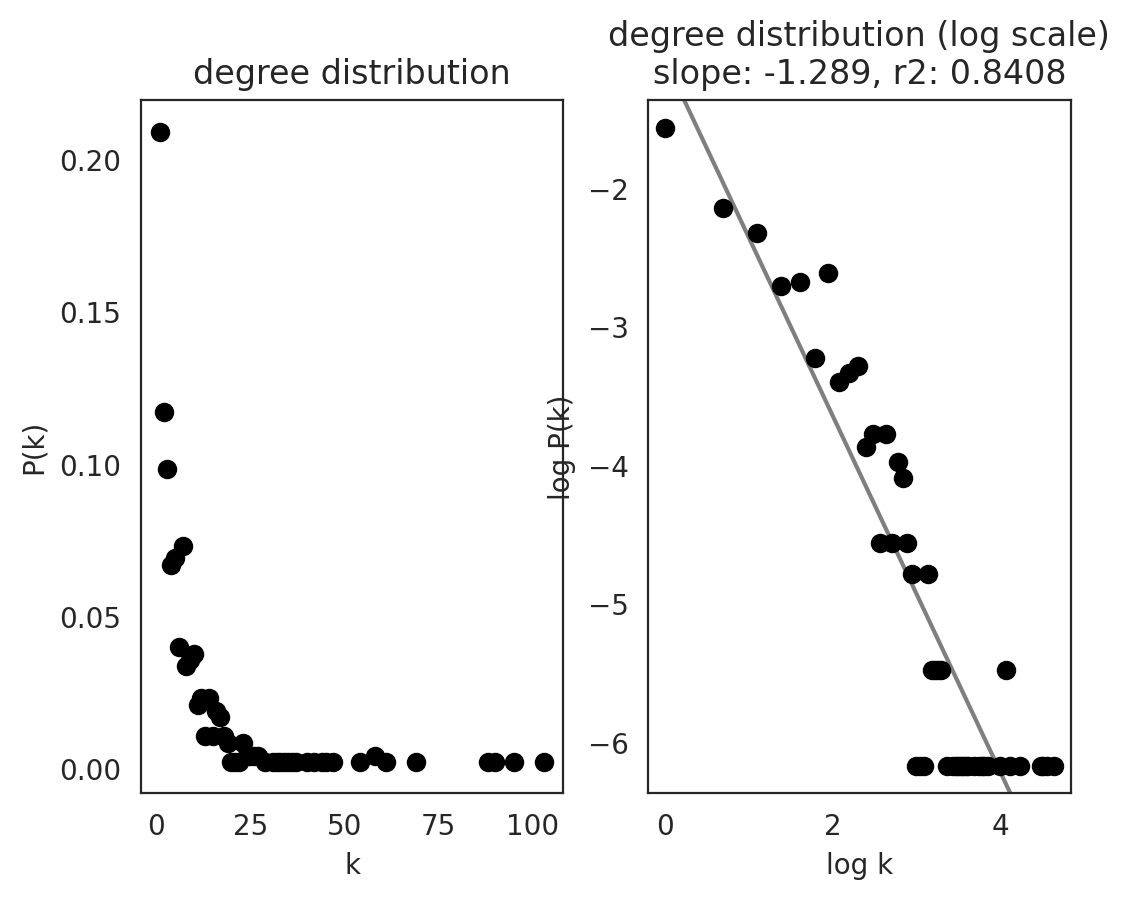

NMPs


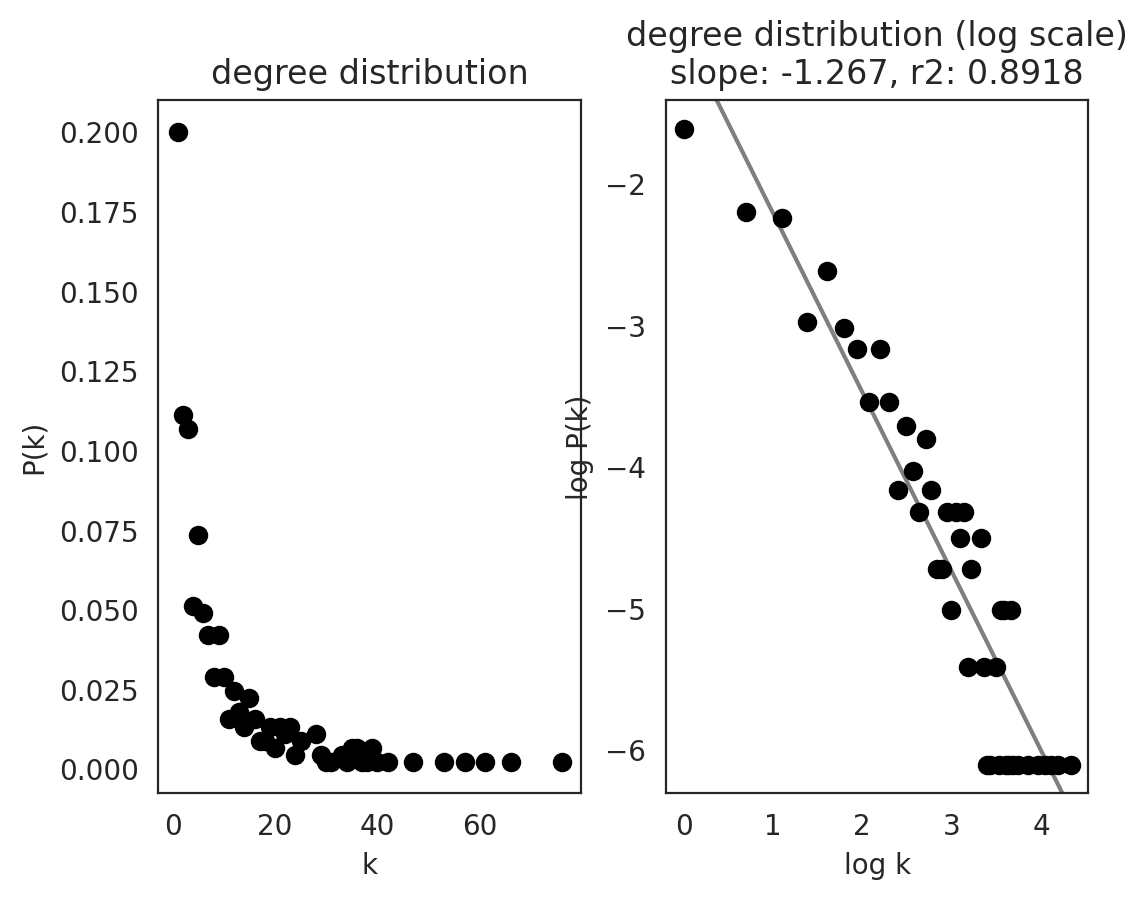

Neural_Anterior


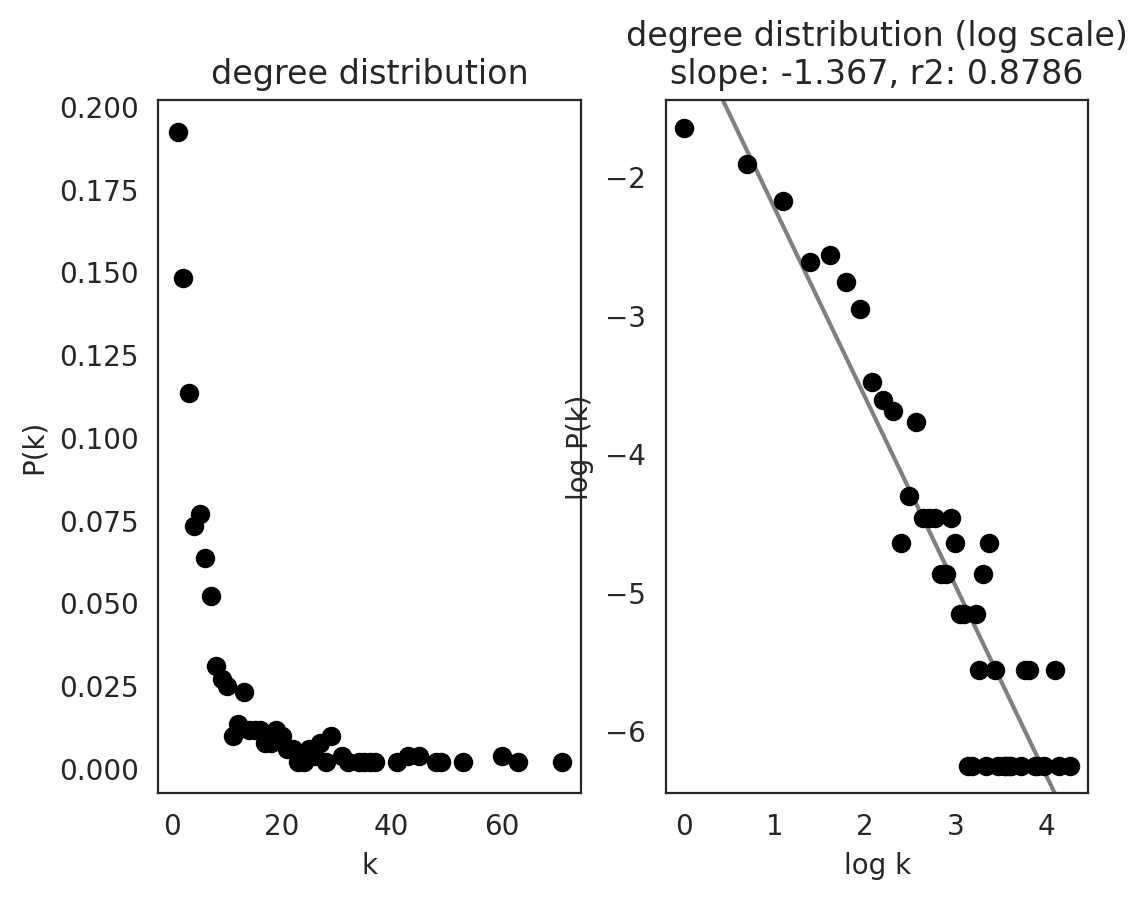

Neural_Crest


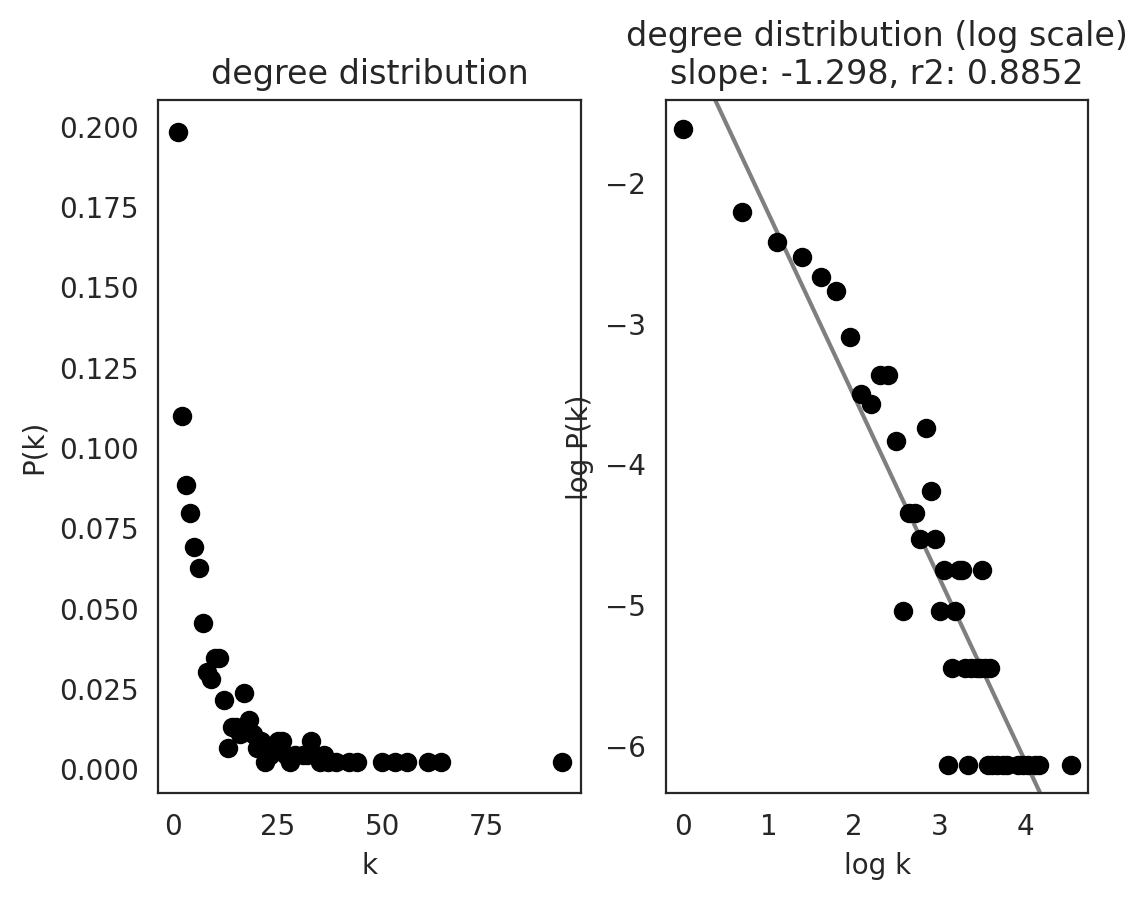

Neural_Posterior


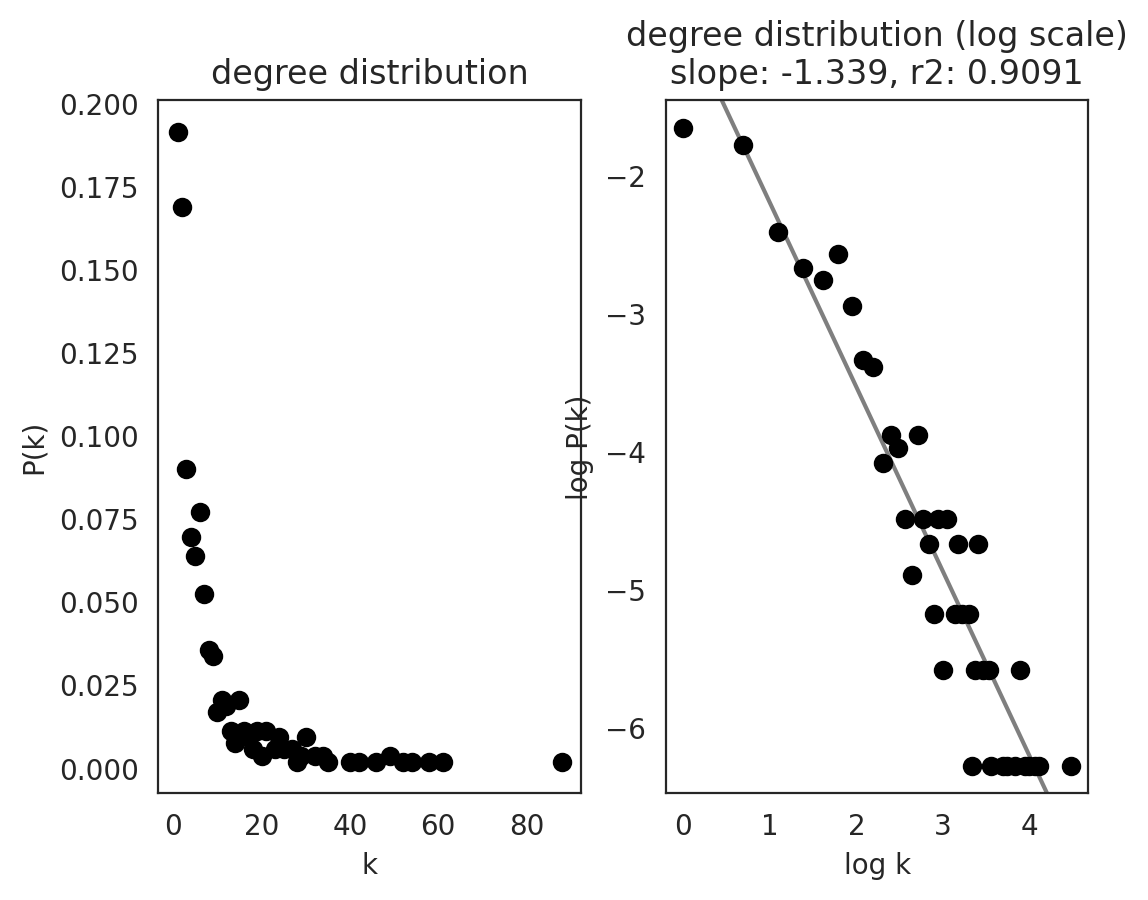

Notochord


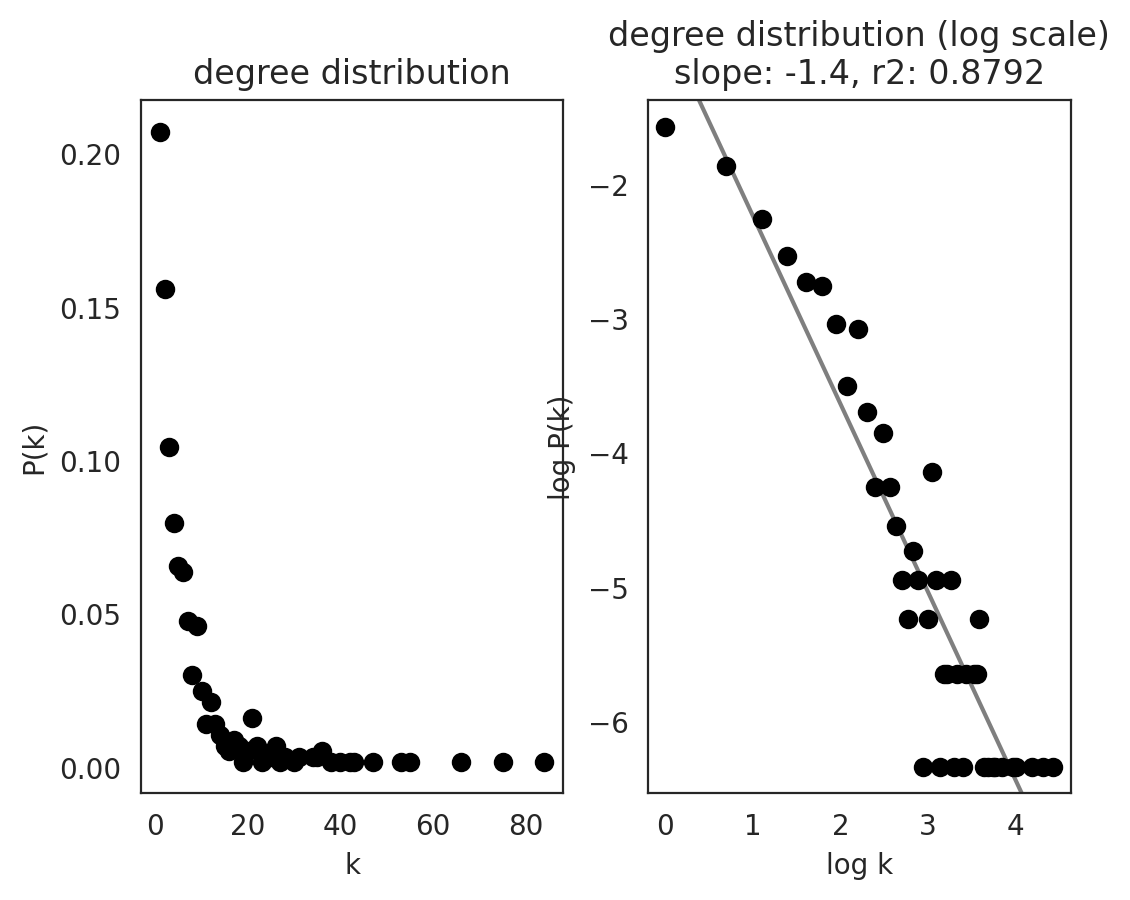

PSM


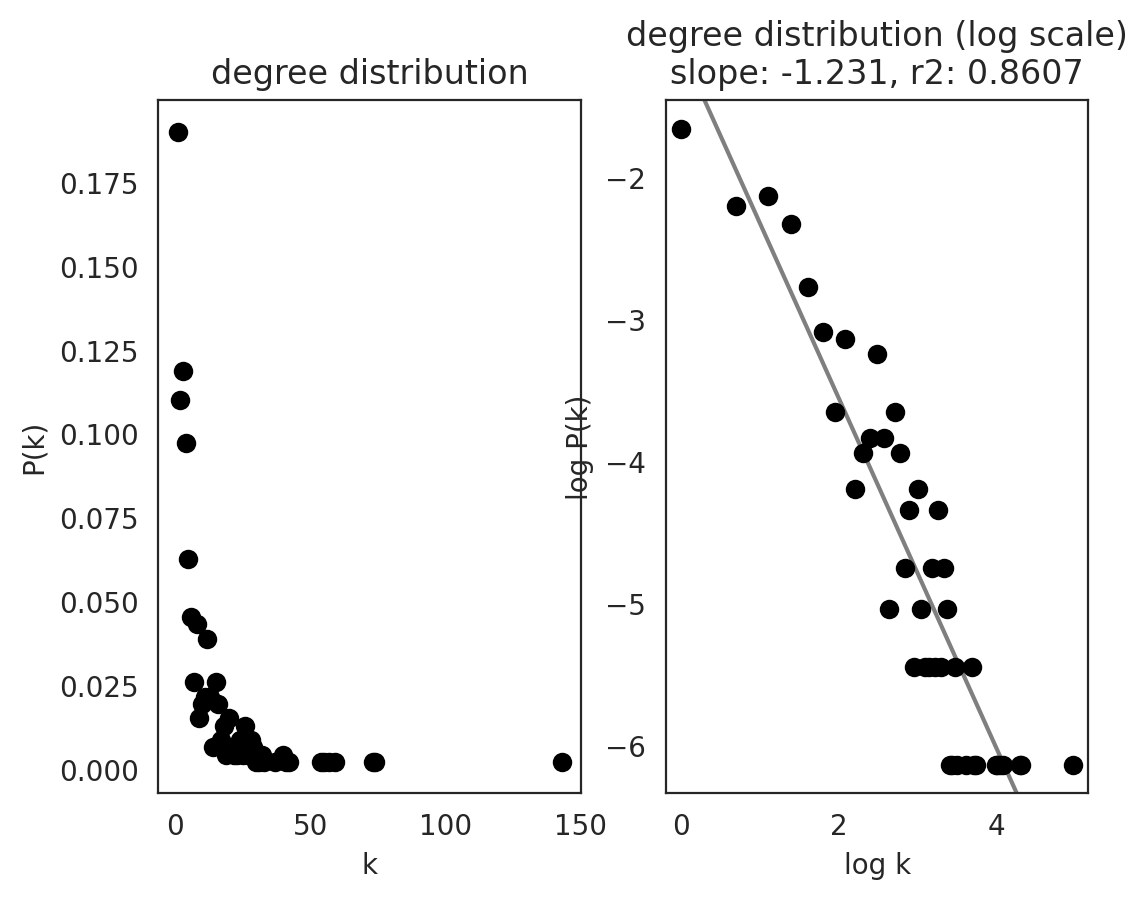

Somites


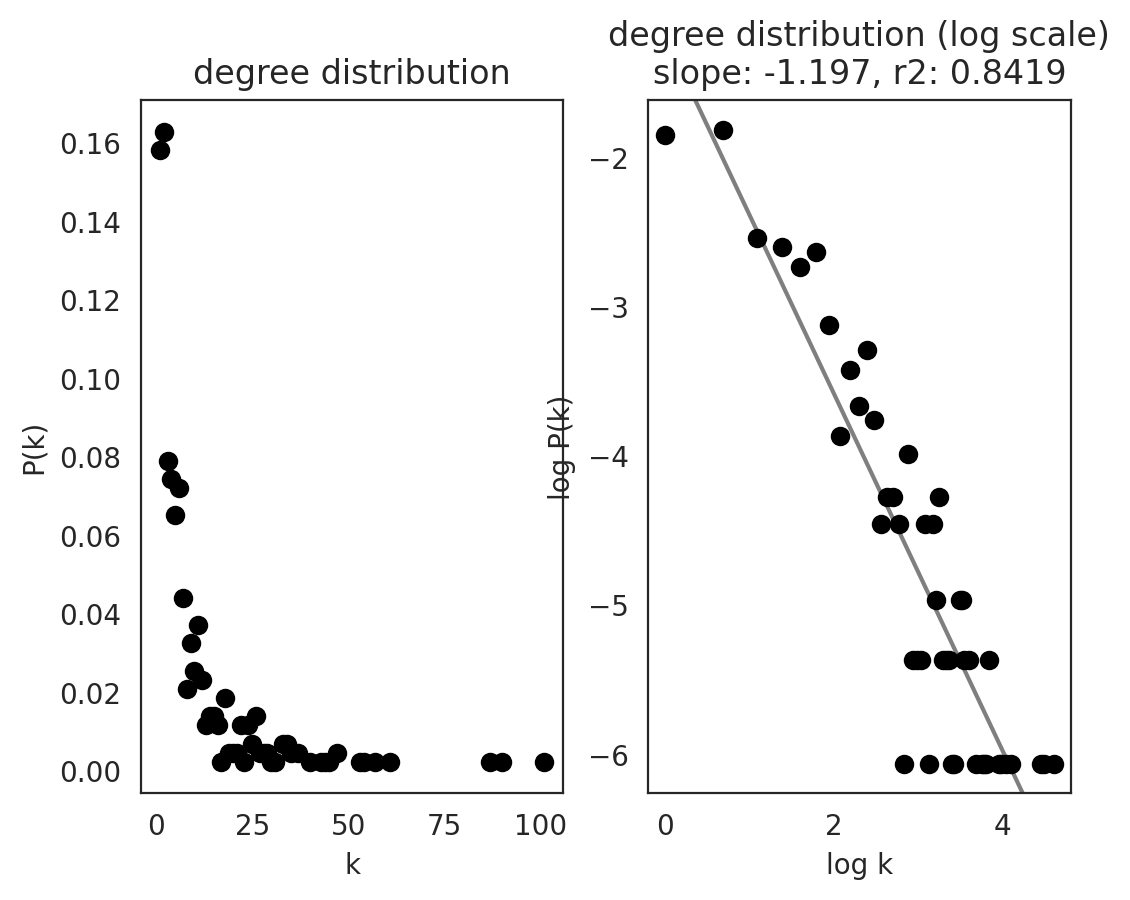

unassigned


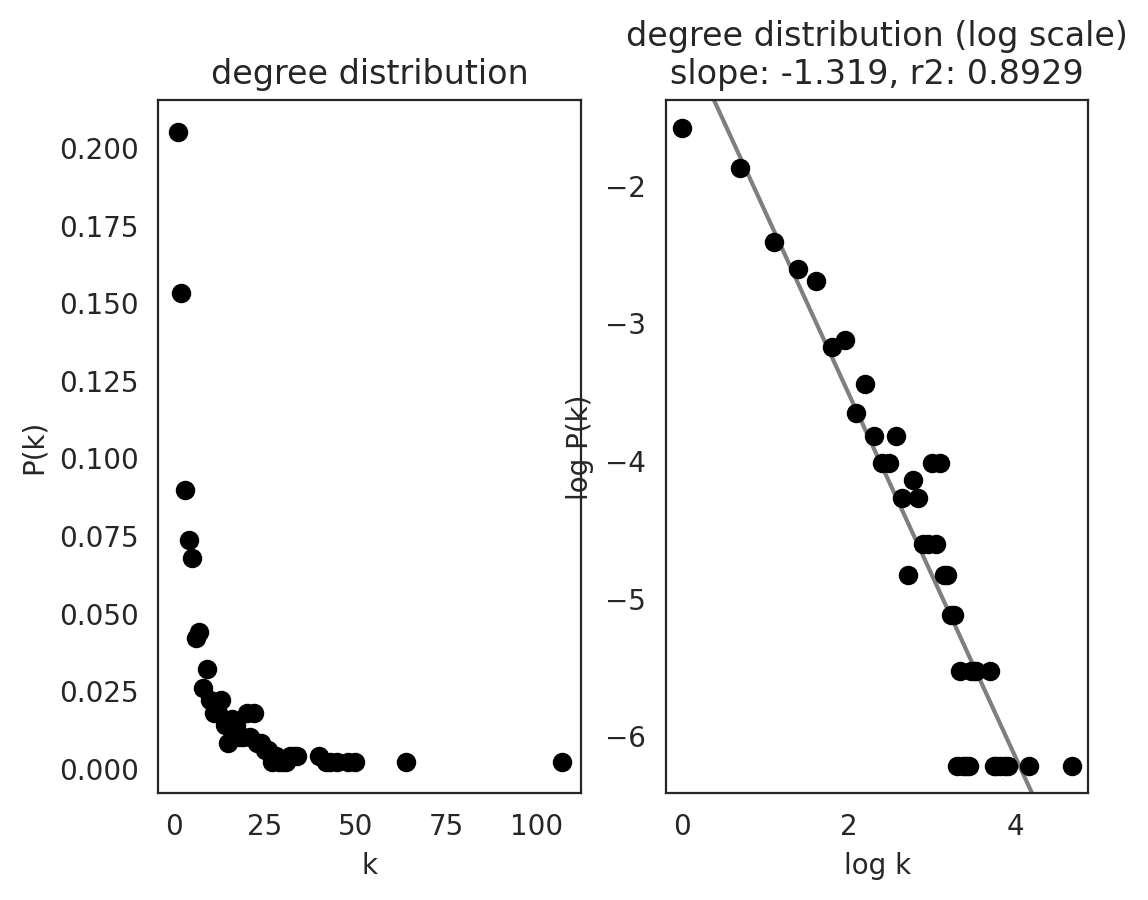

In [59]:
links.plot_degree_distributions(plot_model=True, 
                                               #save=f"{save_folder}/degree_distribution/",
                                               )

In [60]:
plt.rcParams["figure.figsize"] = [6, 4.5]

## 5.3. Calculate network score

Next, we calculate several network score using some R libraries.
Please make sure that R libraries are installed in your PC before running the command below.

`n_jobs` parameter in `get_score` function controls number of jobs to run in parallel. -1 means using all processors. !!This parameter is only available on celloracle >= 0.9.1.

## **NOTE** 

the network scores are computed for "filtered_links". So, if we decide to redo the filter_links, then it means that we need to re-do everything downstream (network score computing, etc.)

In [61]:
# # Calculate network scores. It takes several minutes.
# links.get_score(n_jobs=-1)

The score is stored as a attribute called "merged_score", and the score will also be saved in a folder in your computer.

In [62]:
links.merged_score.head()

degree_all  degree_in  degree_out  clustering_coefficient  \
arxa            129          3         126                0.028952   
foxd5            93          1          92                0.024845   
mef2ca           63          6          57                0.092090   
foxd3            81          3          78                0.048951   
uncx4.1          68          4          64                0.068531   

         clustering_coefficient_weighted  degree_centrality_all  \
arxa                            0.031560               0.277419   
foxd5                           0.026485               0.200000   
mef2ca                          0.109684               0.135484   
foxd3                           0.060225               0.174194   
uncx4.1                         0.084822               0.146237   

         degree_centrality_in  degree_centrality_out  betweenness_centrality  \
arxa                 0.006452               0.270968                    3115   
foxd5                0.002151               0.197849                    2472   
mef2ca               0.012903               0.122581                    3446   
foxd3                0.006452               0.167742                    1386   
uncx4.1              0.008602               0.137634                    3900   

         closeness_centrality  eigenvector_centrality  page_rank  \
arxa                 0.036217                1.000000   0.001636   
foxd5                0.030826                0.735348   0.001591   
mef2ca               0.027532                0.608719   0.001744   
foxd3                0.031245                0.534289   0.001973   
uncx4.1              0.026220                0.432185   0.001880   

         assortative_coefficient  average_path_length  community_random_walk  \
arxa                   -0.383748             0.198416                      4   
foxd5                  -0.383748             0.198416                      4   
mef2ca                 -0.383748             0.198416                      4   
foxd3                  -0.383748             0.198416                      4   
uncx4.1                -0.383748             0.198416                      1   

         module  connectivity  participation           role        cluster  
arxa          4      7.489389       0.268204  Connector Hub  Adaxial_Cells  
foxd5         4      4.552854       0.416115  Connector Hub  Adaxial_Cells  
mef2ca        4      3.348121       0.241667  Connector Hub  Adaxial_Cells  
foxd3         4      3.574009       0.451019  Connector Hub  Adaxial_Cells  
uncx4.1       2      4.347617       0.549587  Connector Hub  Adaxial_Cells

In [65]:
links.merged_score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6977 entries, arxa to id2a
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   degree_all                       6977 non-null   int64  
 1   degree_in                        6977 non-null   int64  
 2   degree_out                       6977 non-null   int64  
 3   clustering_coefficient           6977 non-null   float64
 4   clustering_coefficient_weighted  6977 non-null   float64
 5   degree_centrality_all            6977 non-null   float64
 6   degree_centrality_in             6977 non-null   float64
 7   degree_centrality_out            6977 non-null   float64
 8   betweenness_centrality           6977 non-null   int64  
 9   closeness_centrality             3144 non-null   float64
 10  eigenvector_centrality           6977 non-null   float64
 11  page_rank                        6977 non-null   float64
 12  assortative_coefficien

## 6.4. Save

Save processed GRN. We use this file in the next notebook; "in silico perturbation with GRNs". 

In [52]:
output_filepath

'/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/'

In [53]:
# Save Links object.
links.to_hdf5(file_path=output_filepath + "08_TDR118_celltype_GRNs.celloracle.links")

In [32]:
# links = co.load_hdf5(file_path=output_filepath + "08_TDR118_celltype_GRNs.celloracle.links")

In [6]:
# # You can load files with the following command.
# links = co.load_hdf5(file_path="../TDR118_15somite_GRN_coarse_celltypes/links.celloracle.links")


In [60]:
links.filtered_links

{'Adaxial_Cells':          source            target  coef_mean  coef_abs             p  \
 166079   hmga1a  si:ch73-281n10.2   0.104442  0.104442  7.043193e-14   
 27753      sp5l            cirbpa   0.072111  0.072111  9.413705e-12   
 166050     sp5l  si:ch73-281n10.2   0.065385  0.065385  7.144858e-13   
 171659    fezf1             slit3   0.064806  0.064806  3.475235e-15   
 27743      egr4            cirbpa   0.063309  0.063309  6.825804e-09   
 ...         ...               ...        ...       ...           ...   
 23390     foxd5             cdh15   0.010749  0.010749  4.149559e-12   
 104056  hoxa10b             lpar1   0.010749  0.010749  1.434802e-12   
 74330    hoxb9a             h3f3d   0.010748  0.010748  1.592915e-07   
 102267  nkx2.2a           limch1a   0.010748  0.010748  3.522194e-12   
 100743  barhl1b             ldb3a   0.010747  0.010747  4.429684e-09   
 
             -logp  
 166079  13.152230  
 27753   11.026239  
 166050  12.146006  
 171659  14.459016  


# 7. Network analysis; Network score for each gene
The Links class has many functions to visualize network score.
See the documentation for the details of the functions.

## 7.1. Network score in each cluster


We have calculated several network scores using different centrality metrics.
We can use the centrality score to identify key regulatory genes because centrality is one of the important indicators of network structure (https://en.wikipedia.org/wiki/Centrality). 

Let's visualize genes with high network centrality.


In [62]:
oracle.adata.var_names

Index(['msgn1', 'BX649468.1', 'ripply2', 'chrm2a', 'FAR2', 'phlda1', 'pde3a',
       'CU928073.1', 'cd9b', 'ntf3',
       ...
       'fibina', 'rbl2', 'irx5b', 'irx3b', 'urahb', 'igl4v10', 'NC-002333.17',
       'mt-co2', 'mt-atp6', 'mt-co3'],
      dtype='object', length=3000)

In [64]:
# Check cluster name
links.cluster

['Adaxial_Cells',
 'Differentiating_Neurons',
 'Endoderm',
 'Epidermal',
 'Lateral_Mesoderm',
 'Muscle',
 'NMPs',
 'Neural_Anterior',
 'Neural_Crest',
 'Neural_Posterior',
 'Notochord',
 'PSM',
 'Somites',
 'unassigned']

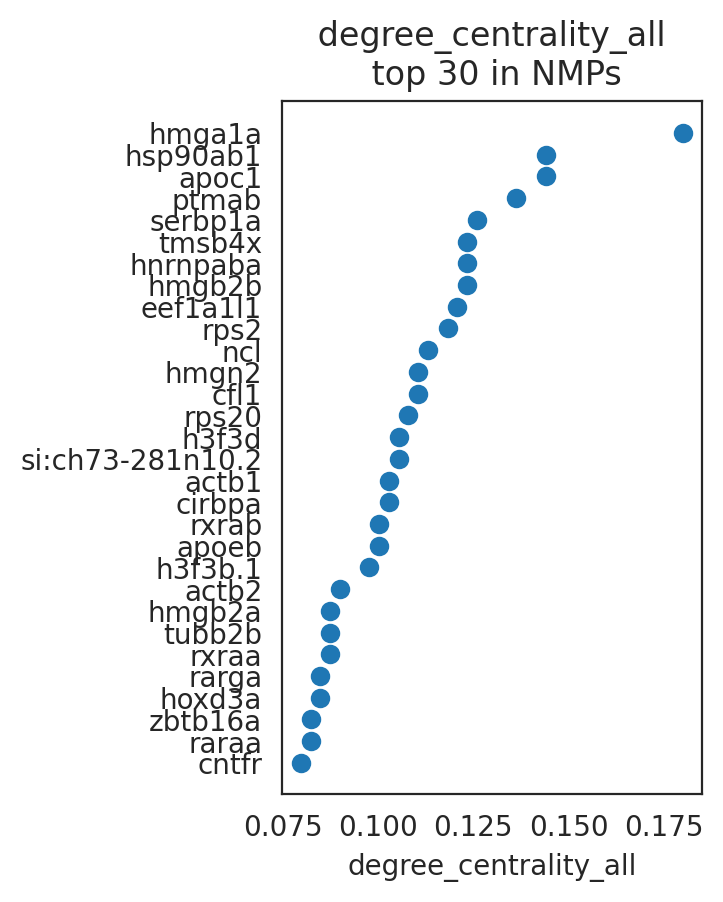

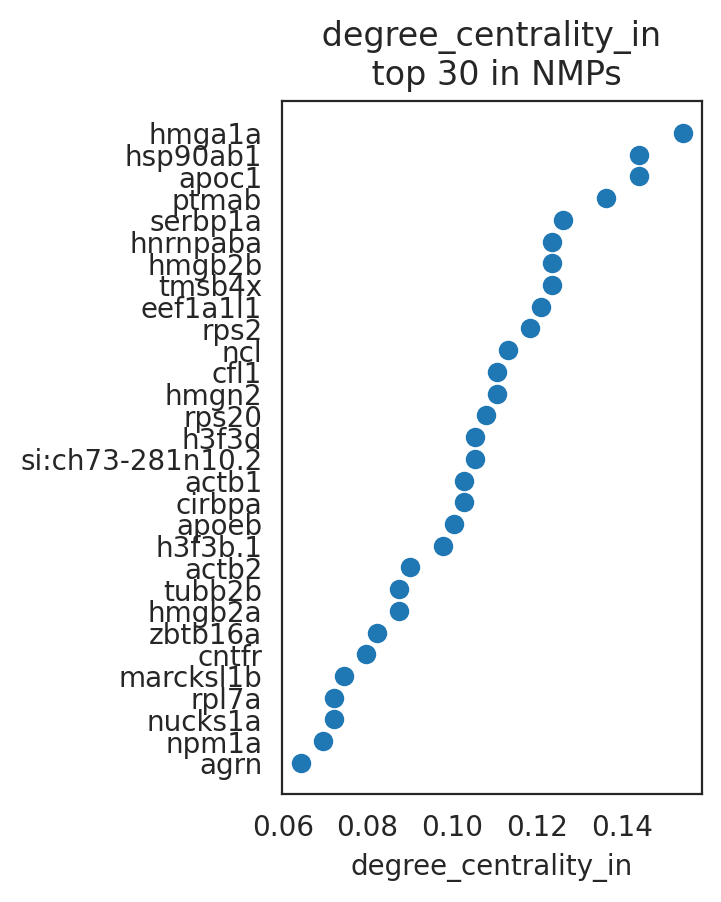

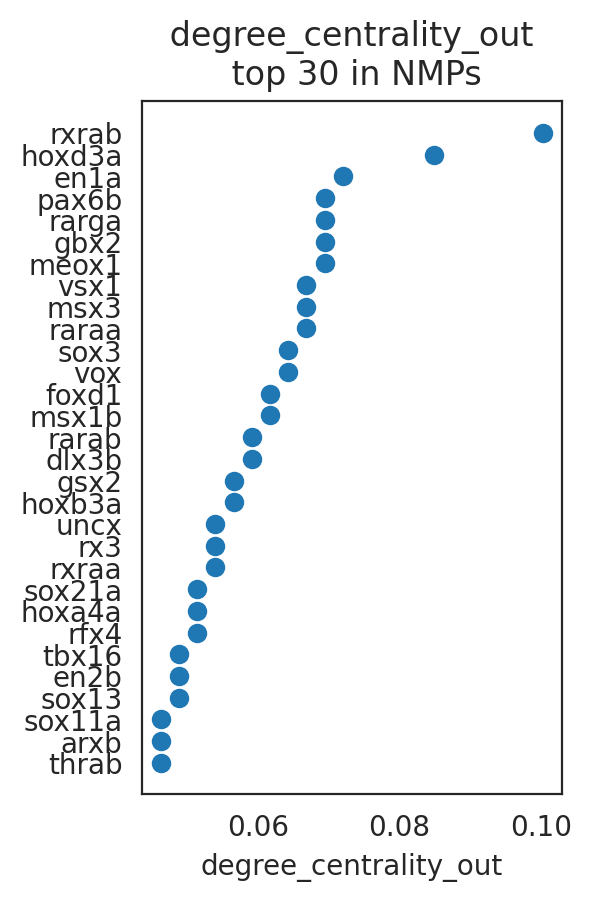

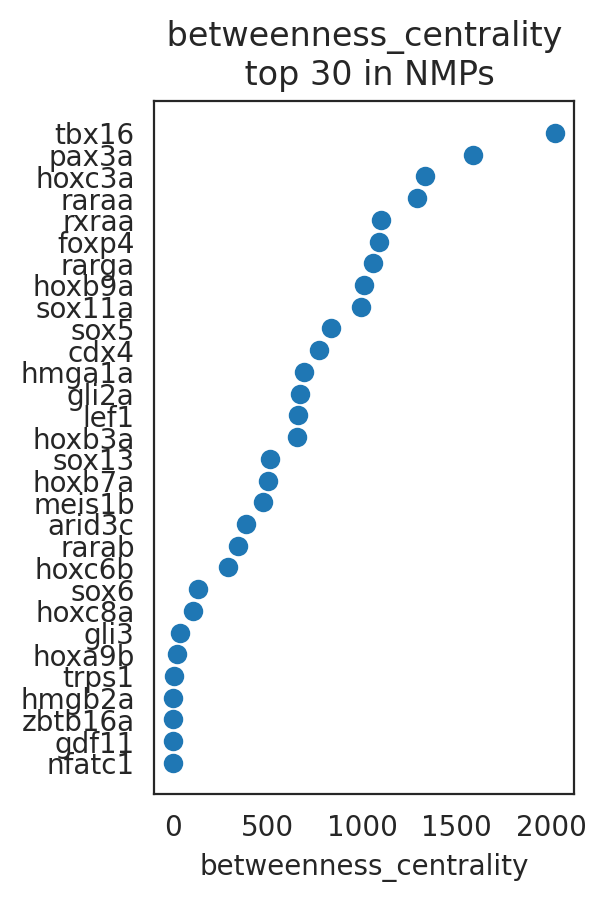

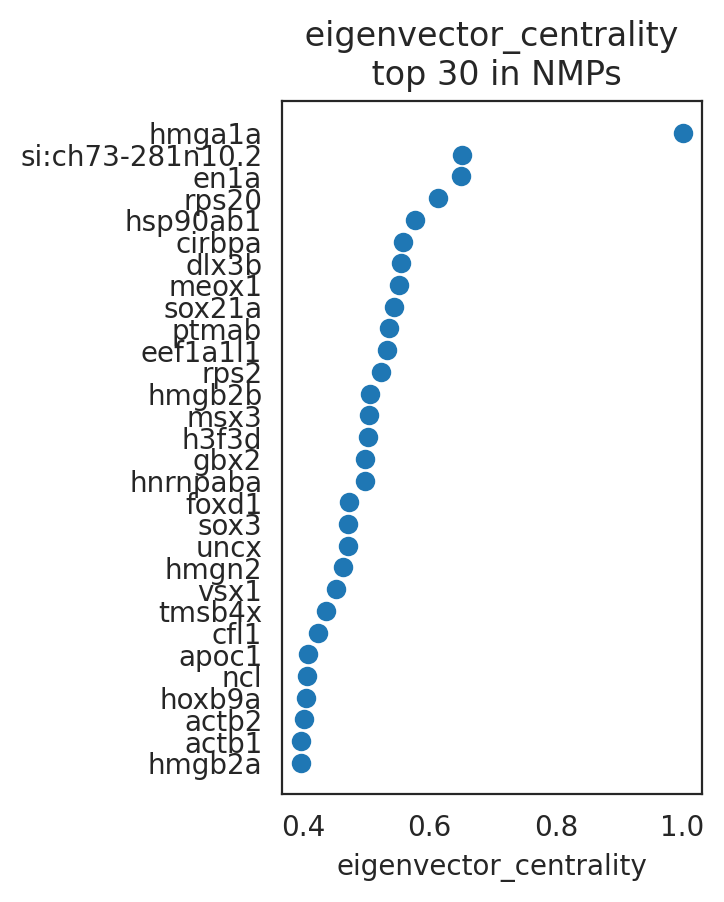

In [65]:
# Visualize top n-th genes that have high scores.
links.plot_scores_as_rank(cluster="NMPs", n_gene=30)#, 
                          #save="TDR118_15somite_GRN_coarse_celltypes/ranked_score")

## 7.2. Network score comparison between two clusters


By comparing network scores between two clusters, we can analyze differences in GRN structure.

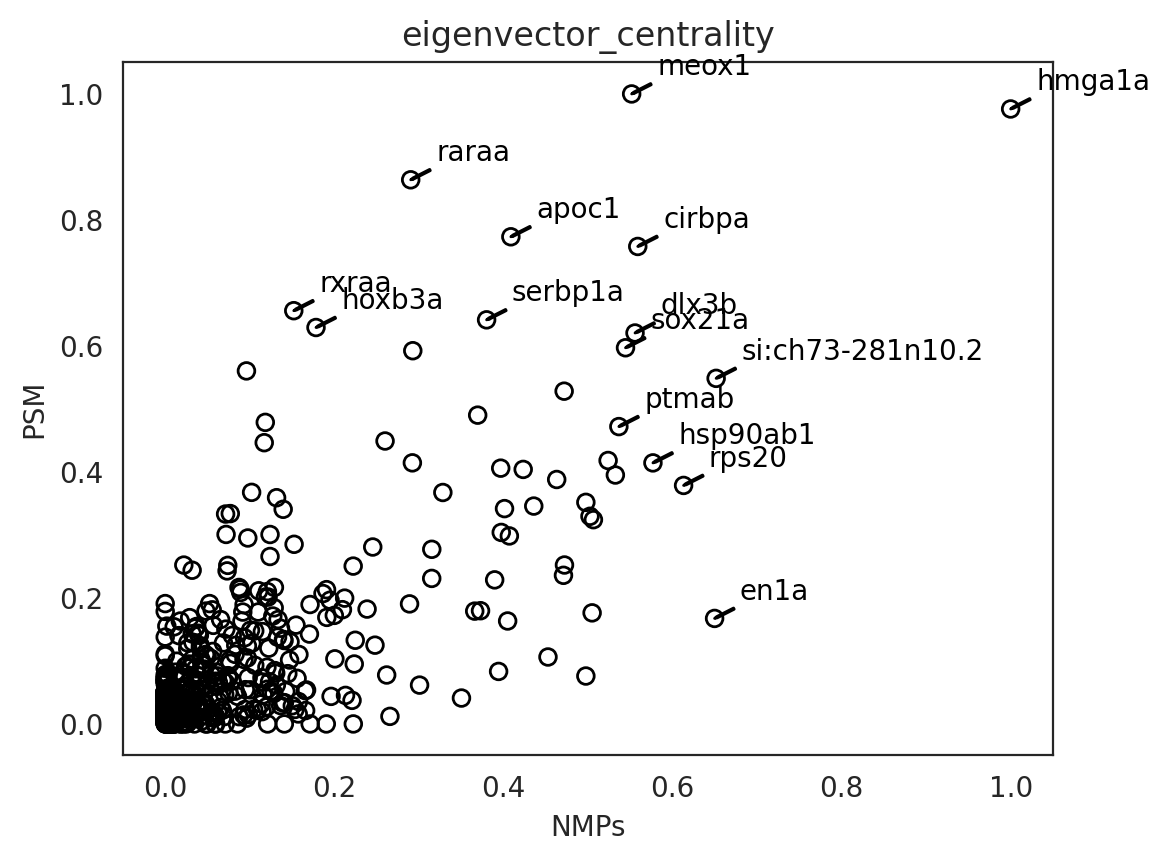

In [68]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="NMPs", cluster2="PSM", 
                               percentile=98) #, save="TDR118_15somite_GRN_coarse_celltypes/score_comparison")

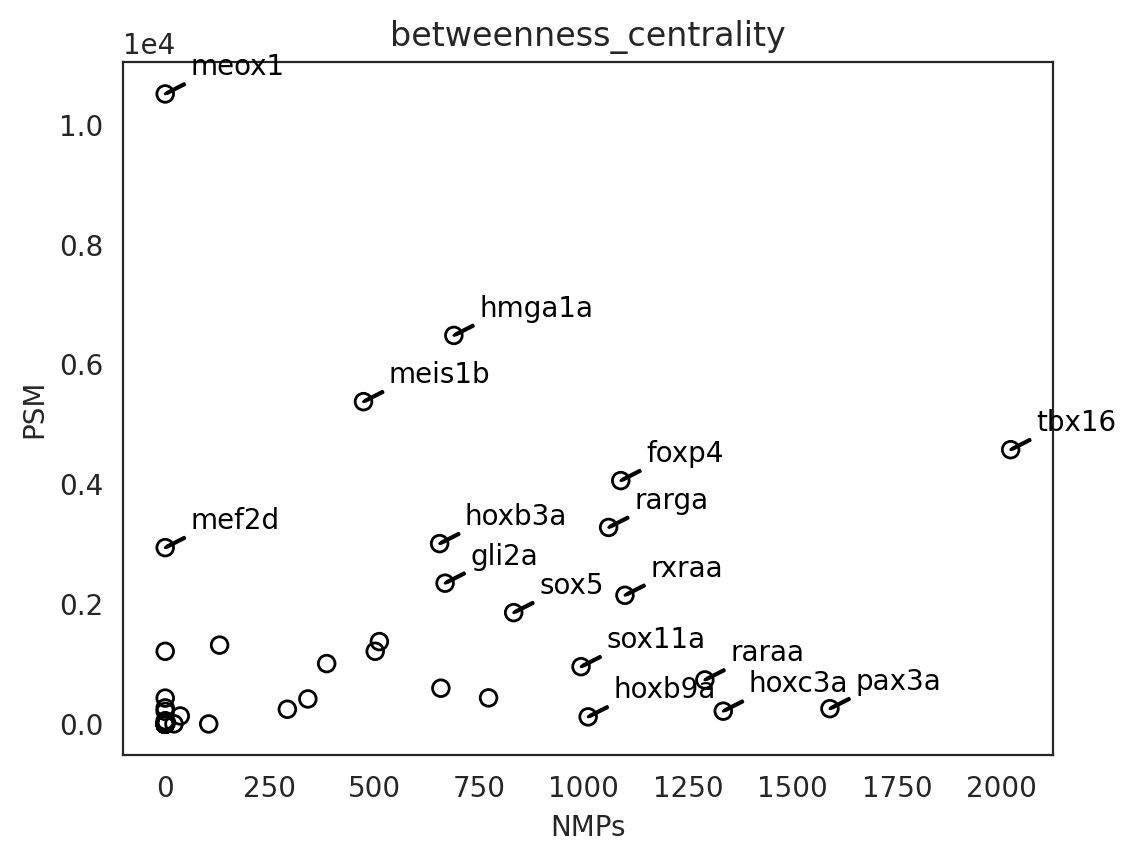

In [69]:

plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="NMPs", cluster2="PSM", 
                               percentile=98) #, save="TDR118_15somite_GRN_coarse_celltypes/score_comparison")

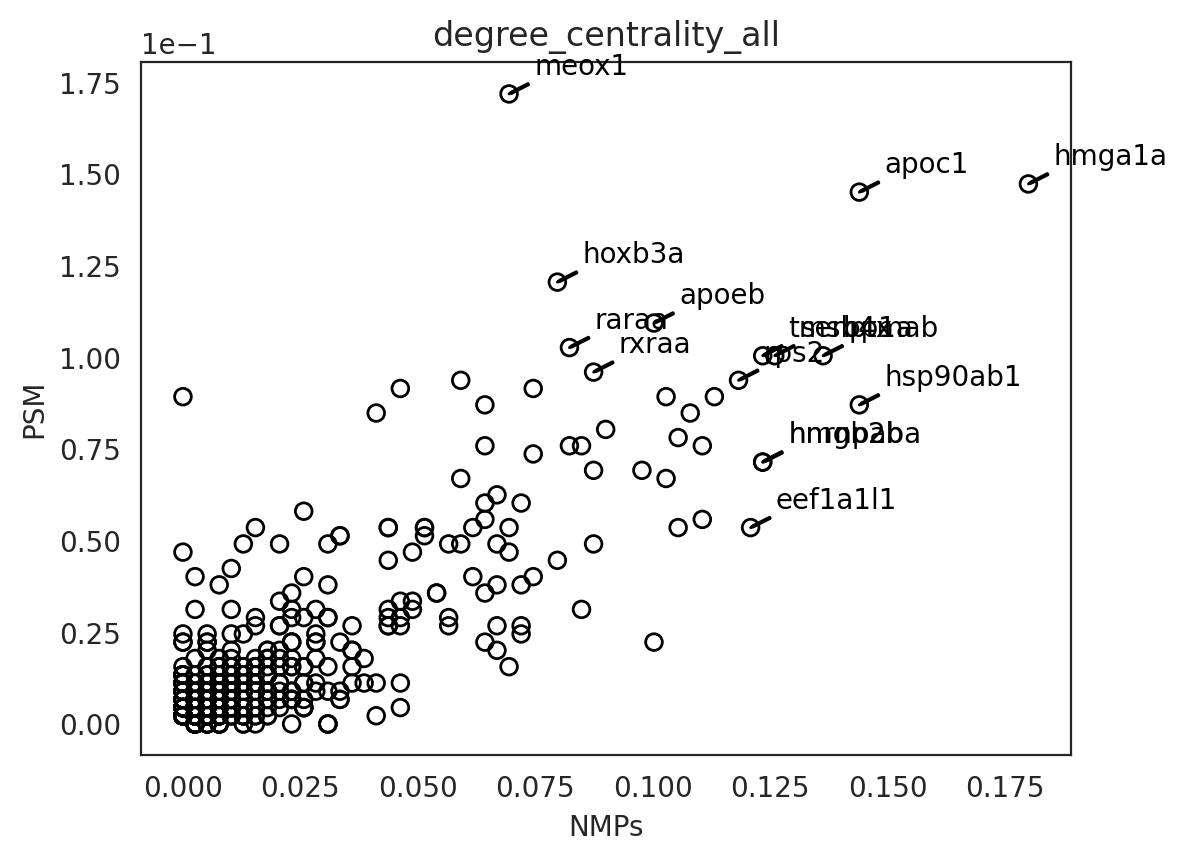

In [70]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="degree_centrality_all",
                               cluster1="NMPs", cluster2="PSM", 
                               percentile=98) #, save="TDR118_15somite_GRN_coarse_celltypes/score_comparison")

## 7.3. Network score dynamics
In the following session, we focus on how a gene's network score changes during the differentiation.

Using Gata2, we will demonstrate how you can visualize networks scores for a single gene.

Gata2 is known to play an essential role in the early MEP and GMP populations. .

tbx16


/home/yang-joon.kim/.local/lib/python3.8/site-packages/celloracle/network_analysis/gene_analysis.py:320: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=res, y="cluster", x=value,
/home/yang-joon.kim/.local/lib/python3.8/site-packages/celloracle/network_analysis/gene_analysis.py:320: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=res, y="cluster", x=value,
/home/yang-joon.kim/.local/lib/python3.8/site-packages/celloracle/network_analysis/gene_analysis.py:320: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=res, y="cluster", x=value,


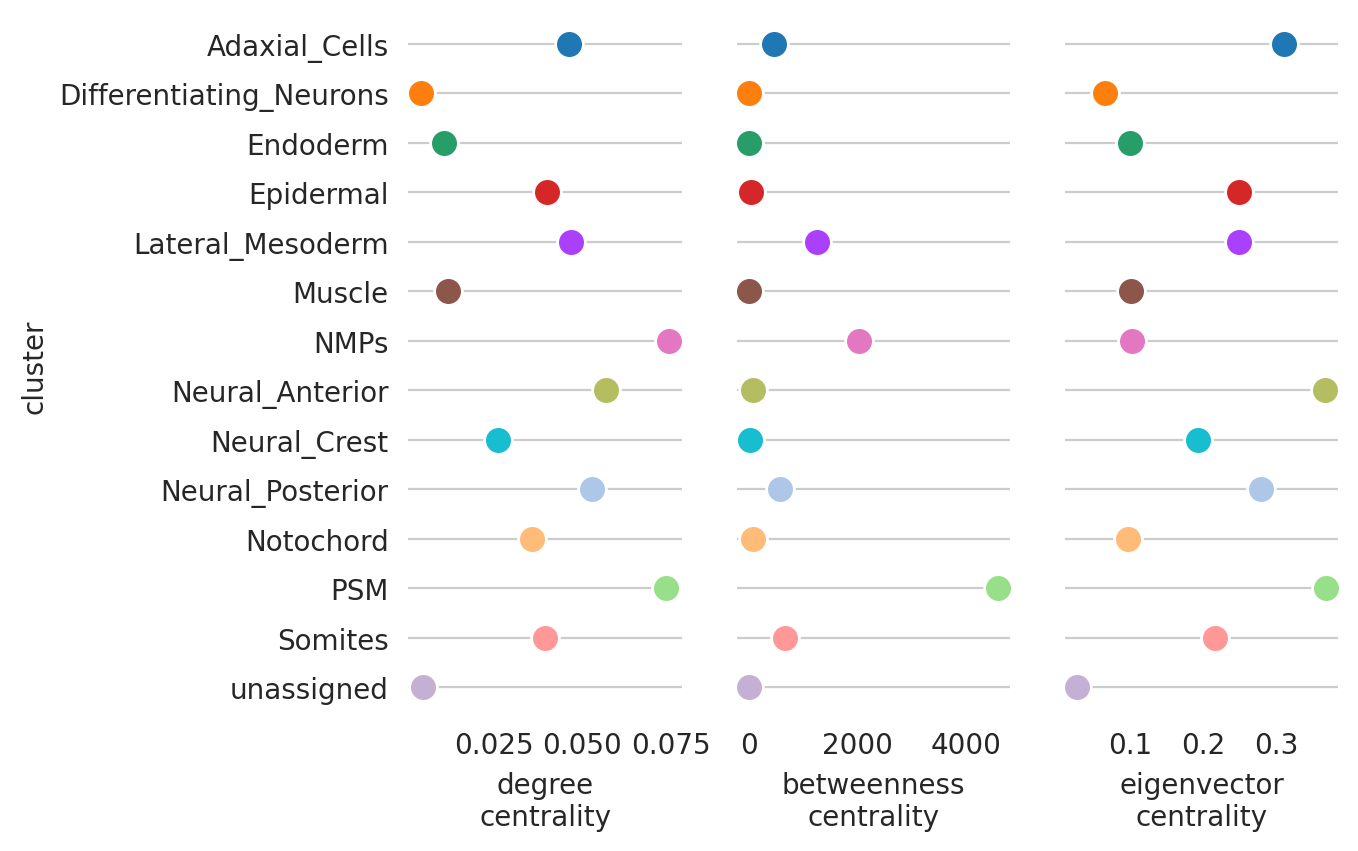

In [74]:
# Visualize Gata2 network score dynamics
links.plot_score_per_cluster(goi="tbx16")#, save="TDR118_15somite_GRN_coarse_celltypes/network_score_per_gene/")

If a gene have no connections in a cluster, it is impossible to calculate network degree scores.
Thus the scores will not be shown.
For example, Cebpa have no connection in the erythloids clusters, and there is no degree scores for Cebpa in these clusters as follows.

pax6a


/home/yang-joon.kim/.local/lib/python3.8/site-packages/celloracle/network_analysis/gene_analysis.py:320: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=res, y="cluster", x=value,
/home/yang-joon.kim/.local/lib/python3.8/site-packages/celloracle/network_analysis/gene_analysis.py:320: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=res, y="cluster", x=value,
/home/yang-joon.kim/.local/lib/python3.8/site-packages/celloracle/network_analysis/gene_analysis.py:320: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=res, y="cluster", x=value,


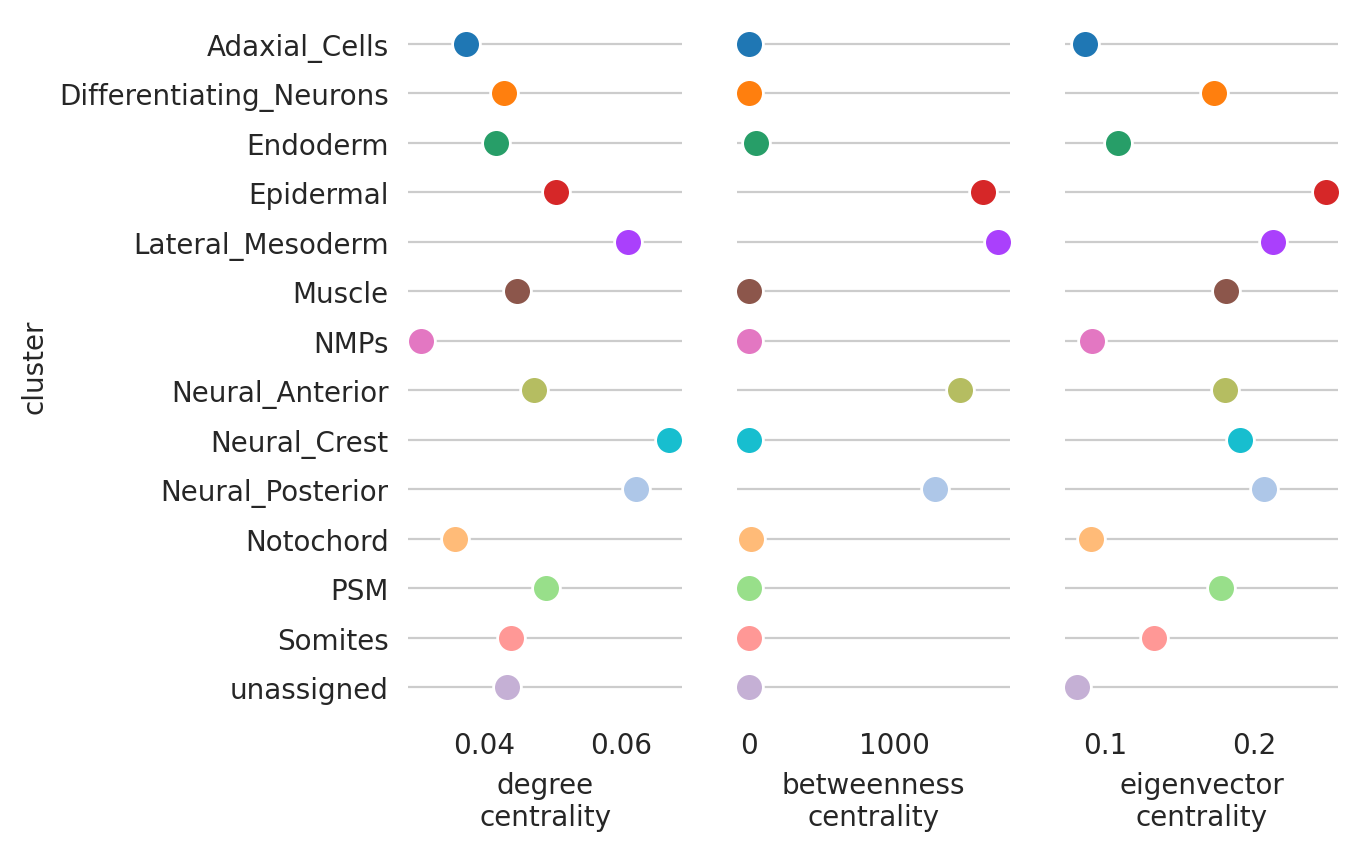

In [75]:
links.plot_score_per_cluster(goi="pax6a")

You can check filtered network edge as follows.

In [76]:
cluster_name = "NMPs"
filtered_links_df = links.filtered_links[cluster_name]
filtered_links_df.head()

source            target  coef_mean  coef_abs             p      -logp
171664  nfatc1             slit3   0.167520  0.167520  6.099314e-13  12.214719
166079  hmga1a  si:ch73-281n10.2   0.134133  0.134133  8.328944e-17  16.079410
171665  creb5b             slit3   0.118250  0.118250  2.857576e-08   7.544002
27748     her9            cirbpa   0.109563  0.109563  5.209617e-10   9.283194
154387   mafbb             rpl7a   0.091194  0.091194  7.477311e-13  12.126255

(array([  4.,   6.,  19., 238.,   0., 479., 963., 190.,  63.,  16.,  10.,
          5.,   2.,   1.,   1.,   1.,   1.,   0.,   0.,   1.]),
 array([-0.05427987, -0.04318989, -0.03209991, -0.02100993, -0.00991995,
         0.00117003,  0.01226001,  0.02334999,  0.03443997,  0.04552995,
         0.05661993,  0.06770991,  0.07879989,  0.08988987,  0.10097985,
         0.11206983,  0.12315981,  0.13424979,  0.14533977,  0.15642975,
         0.16751973], dtype=float32),
 <BarContainer object of 20 artists>)

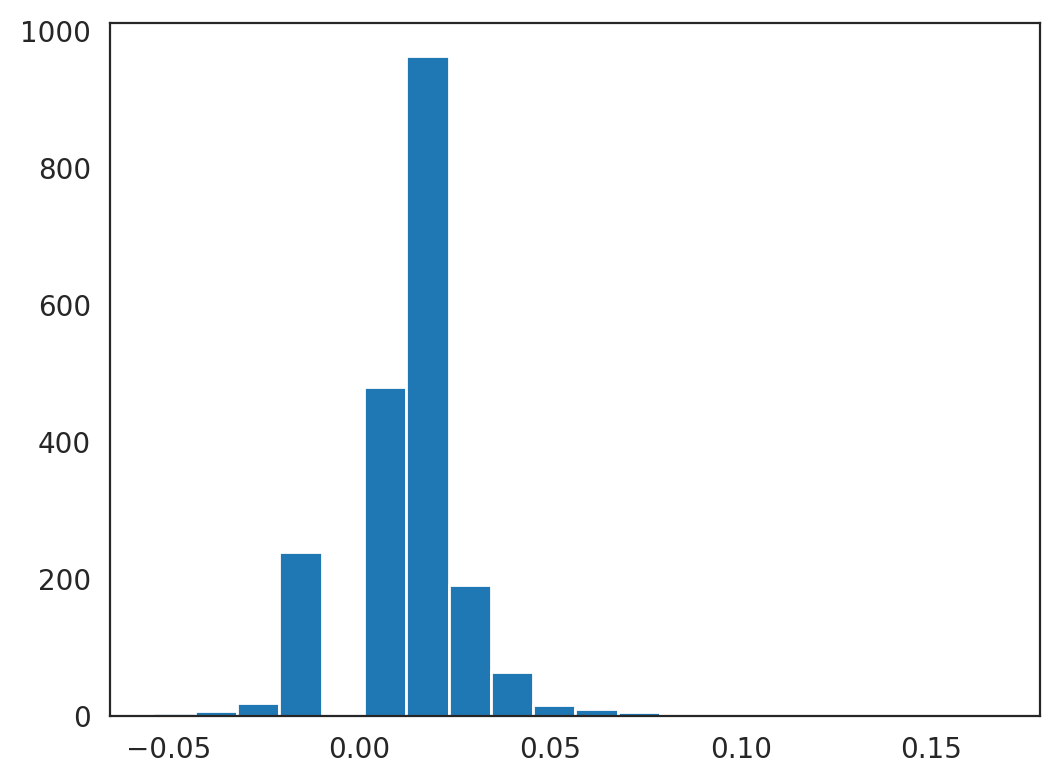

In [79]:
plt.hist(filtered_links_df.coef_mean, bins=20)

## data exploration - with Alejandro on 7/20/2023

In [77]:
filtered_links_df.value_counts()

source  target   coef_mean  coef_abs  p             -logp    
alx4b   actb2     0.011972  0.011972  4.668636e-10  9.330810     1
pax6b   ctnnd2b   0.019362  0.019362  1.399752e-12  11.853949    1
        nova2     0.016700  0.016700  9.239955e-11  10.034330    1
        ncam1b    0.010852  0.010852  7.104874e-07  6.148444     1
        meis1b    0.016022  0.016022  2.720623e-08  7.565332     1
                                                                ..
hoxb3a  notch1a   0.018449  0.018449  2.894996e-13  12.538352    1
        mllt3     0.021569  0.021569  1.653957e-15  14.781476    1
        mki67    -0.010584  0.010584  3.219369e-15  14.492229    1
        lpar1     0.011386  0.011386  4.113130e-11  10.385828    1
zic2b   npm1a     0.016218  0.016218  2.209796e-10  9.655648     1
Name: count, Length: 2000, dtype: int64

In [164]:
links.filtered_links.keys()

dict_keys(['Adaxial_Cells', 'Differentiating_Neurons', 'Endoderm', 'Epidermal', 'Lateral_Mesoderm', 'Muscle', 'NMPs', 'Neural_Anterior', 'Neural_Crest', 'Neural_Posterior', 'Notochord', 'PSM', 'Somites', 'unassigned'])

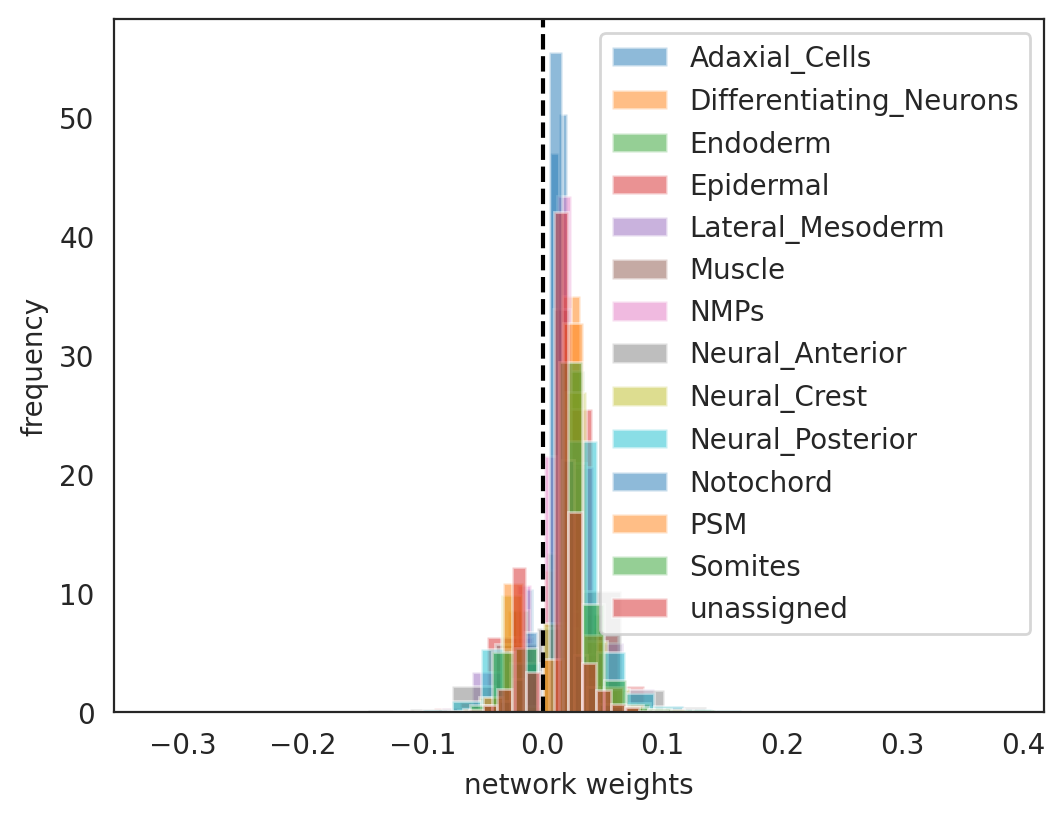

In [80]:
celltypes = links.filtered_links.keys()

plt.figure()

for celltype in celltypes:
    filtered_links_df = links.filtered_links[celltype]
    plt.hist(filtered_links_df["coef_mean"], bins=20, density=True, alpha=0.5, label=celltype)
# Draw a vertical line along the y-axis at x=0
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel("network weights")
plt.ylabel("frequency")
plt.legend()
plt.show()


Text(0, 0.5, 'occurences')

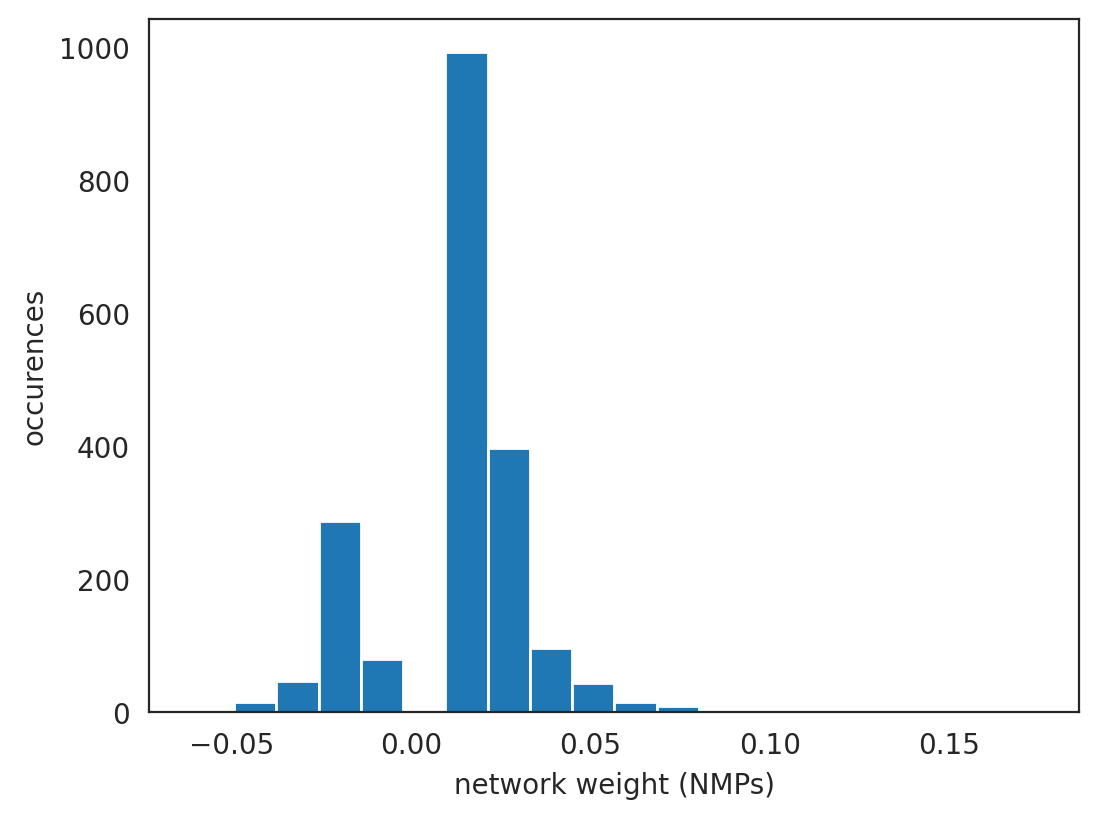

In [81]:
plt.hist(filtered_links_df["coef_mean"], bins=20)
plt.xlabel("network weight (NMPs)")
plt.ylabel("occurences")

Text(0, 0.5, '-log (p_value)')

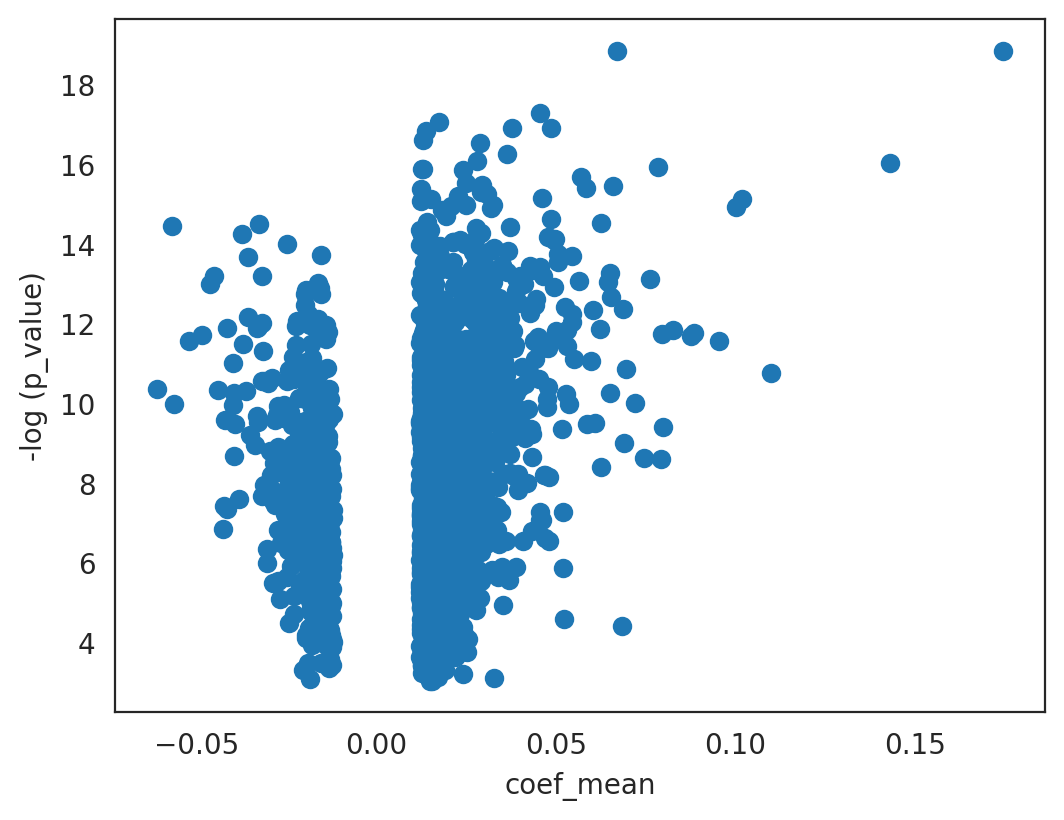

In [82]:
# scatter plot for coef_mean and -log p_value
plt.scatter(filtered_links_df["coef_mean"], filtered_links_df["-logp"])
plt.xlabel("coef_mean")
plt.ylabel("-log (p_value)")

In [85]:
filtered_links_df.sort_values("coef_mean", ascending=False)

source            target  coef_mean  coef_abs             p  \
166079   hmga1a  si:ch73-281n10.2   0.174446  0.174446  1.425083e-19   
154390    mafba             rpl7a   0.142932  0.142932  8.987917e-17   
27799      sox3            cirbpa   0.109816  0.109816  1.673962e-11   
204008   tcf7l2           zbtb16a   0.101832  0.101832  7.442027e-16   
80057    hoxa9b            hmgb2a   0.100233  0.100233  1.158218e-15   
...         ...               ...        ...       ...           ...   
902        etv4             actb1  -0.048603  0.048603  1.953311e-12   
80046   twist1a            hmgb2a  -0.052350  0.052350  2.649423e-12   
8599       mnx1             apoc1  -0.056478  0.056478  1.026318e-10   
8598       gbx2             apoc1  -0.057092  0.057092  3.540801e-15   
161790    six1b           serbp1a  -0.061112  0.061112  4.334704e-11   

            -logp  
166079  18.846160  
154390  16.046341  
27799   10.776255  
204008  15.128309  
80057   14.936210  
...           ...  
902     11.709229  
80046   11.576849  
8599     9.988718  
8598    14.450898  
161790  10.363041  

[2000 rows x 6 columns]

You can confirm that there is no Cebpa connection in Ery_0 cluster.

In [86]:
filtered_links_df[filtered_links_df.source == "sox3"]

source            target  coef_mean  coef_abs             p      -logp
27799    sox3            cirbpa   0.109816  0.109816  1.673962e-11  10.776255
166096   sox3  si:ch73-281n10.2   0.068364  0.068364  3.746339e-05   4.426393
80389    sox3             hmgn2   0.049725  0.049725  7.330988e-15  14.134838
161827   sox3           serbp1a   0.047821  0.047821  4.091331e-12  11.388135
81372    sox3          hnrnpaba   0.042871  0.042871  5.391655e-13  12.268278
85201    sox3          hsp90ab1   0.037212  0.037212  3.727392e-15  14.428595
146434   sox3             ptmab   0.034544  0.034544  4.295737e-13  12.366962
204015   sox3           zbtb16a   0.033184  0.033184  8.822935e-09   8.054387
154624   sox3             rps20   0.030775  0.030775  5.454068e-16  15.263279
26163    sox3              cfl1   0.024636  0.024636  1.006169e-14  13.997329
31827    sox3          col18a1a   0.022645  0.022645  7.340447e-14  13.134278
190637   sox3            tmsb4x   0.022561  0.022561  1.601648e-08   7.795433
124481   sox3             nova2   0.021925  0.021925  5.309203e-14  13.274971
196346   sox3            tubb2b   0.021374  0.021374  1.370980e-11  10.862969
196469   sox3            tubb4b   0.021003  0.021003  1.573776e-08   7.803057
48827    sox3          eef1a1l1   0.019921  0.019921  3.846947e-12  11.414884
1117     sox3             actb2   0.019167  0.019167  4.060796e-10   9.391389
946      sox3             actb1  -0.018842  0.018842  1.260648e-07   6.899406
107721   sox3              mdka   0.017026  0.017026  7.101908e-09   8.148625
174695   sox3             sox13   0.016018  0.016018  2.727081e-11  10.564302
40775    sox3              dag1   0.015530  0.015530  1.455586e-14  13.836962
123540   sox3             nop58   0.015262  0.015262  1.021965e-11  10.990564
195694   sox3            tuba1a   0.013486  0.013486  4.394860e-14  13.357055
57705    sox3             fabp3   0.013426  0.013426  1.482984e-10   9.828864
65079    sox3             foxp4   0.013239  0.013239  3.548933e-08   7.449902

## 7.4. Gene cartography analysis

Gene cartography is a method for gene network analysis.
The method classifies gene into several groups using the network module structure and connections.
It provides us an insight about the role and regulatory mechanism for each gene. 
For more information on gene cartography, please refer to the following paper (https://www.nature.com/articles/nature03288).

The gene cartography will be calculated for the GRN in each cluster.
Thus we can know how the gene cartography change by comparing the the score between clusters.

/home/yang-joon.kim/.local/lib/python3.8/site-packages/celloracle/network_analysis/links_object.py:394: DeprecationWarning: This is the deprecated function. This function will be removed in the future version.
  warnings.warn(


Adaxial_Cells


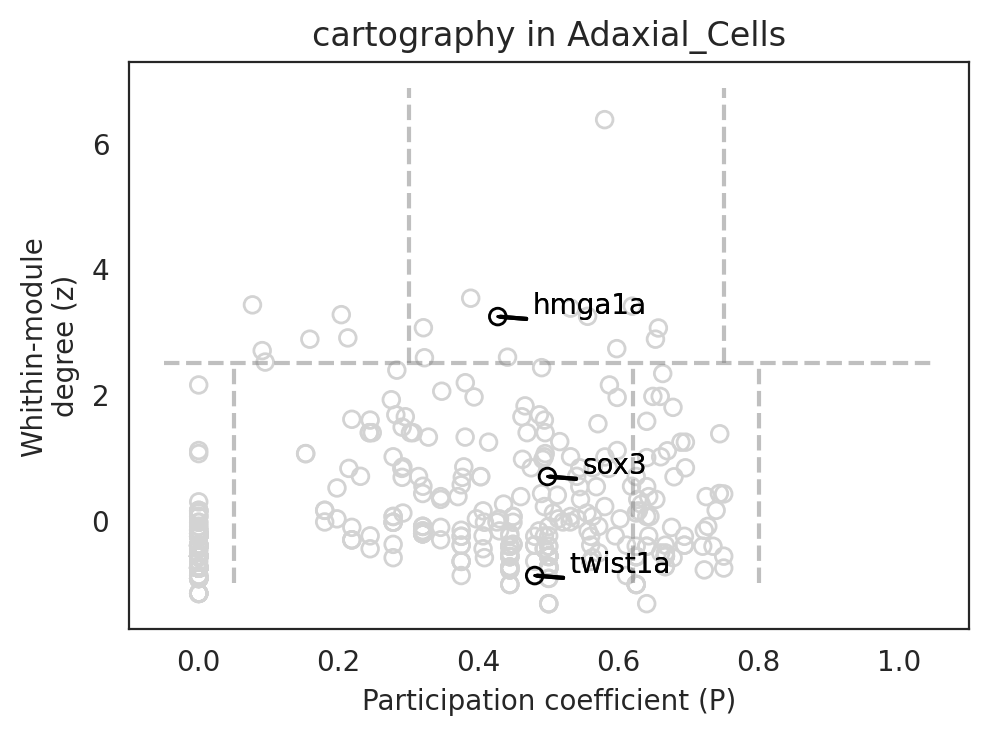

Differentiating_Neurons


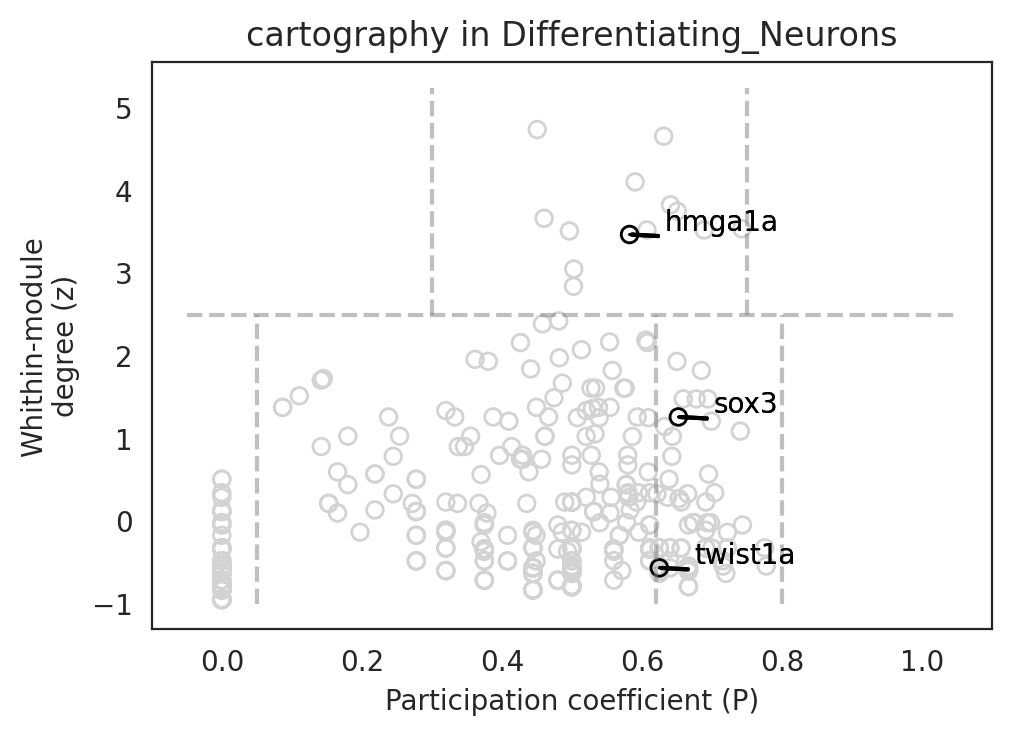

Endoderm


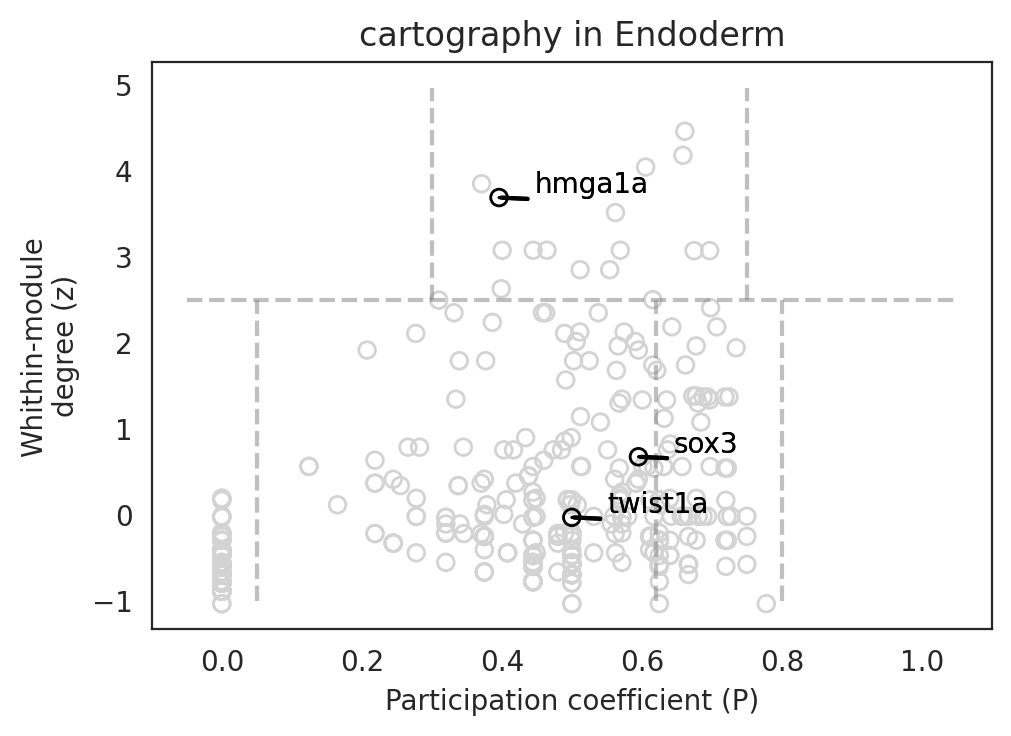

Epidermal


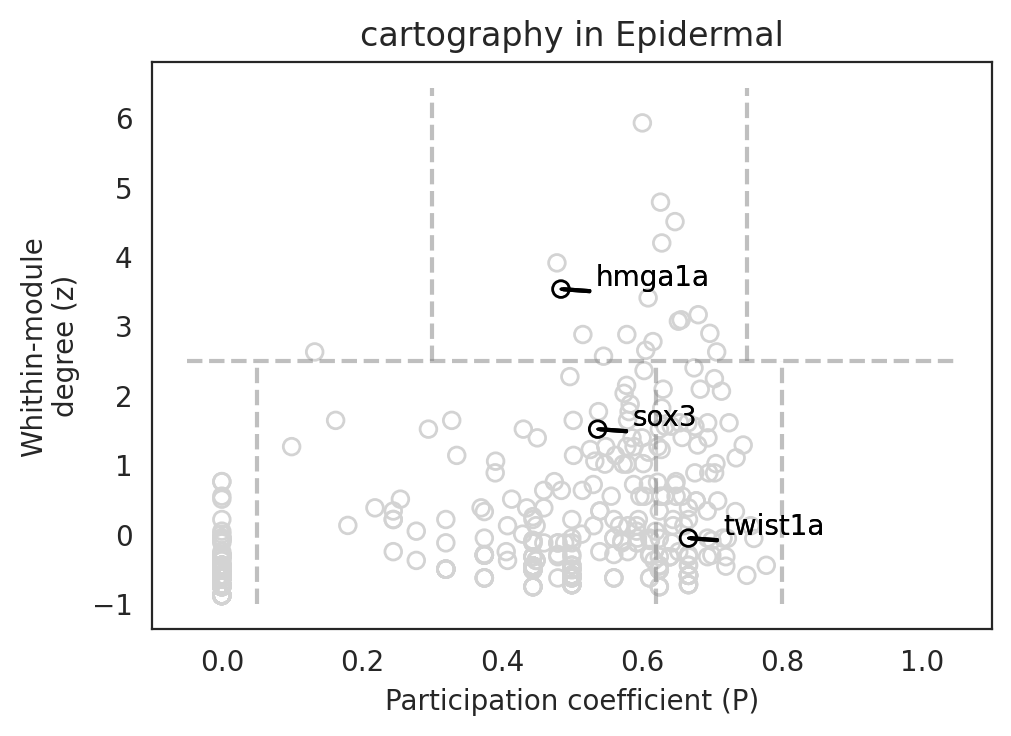

Lateral_Mesoderm


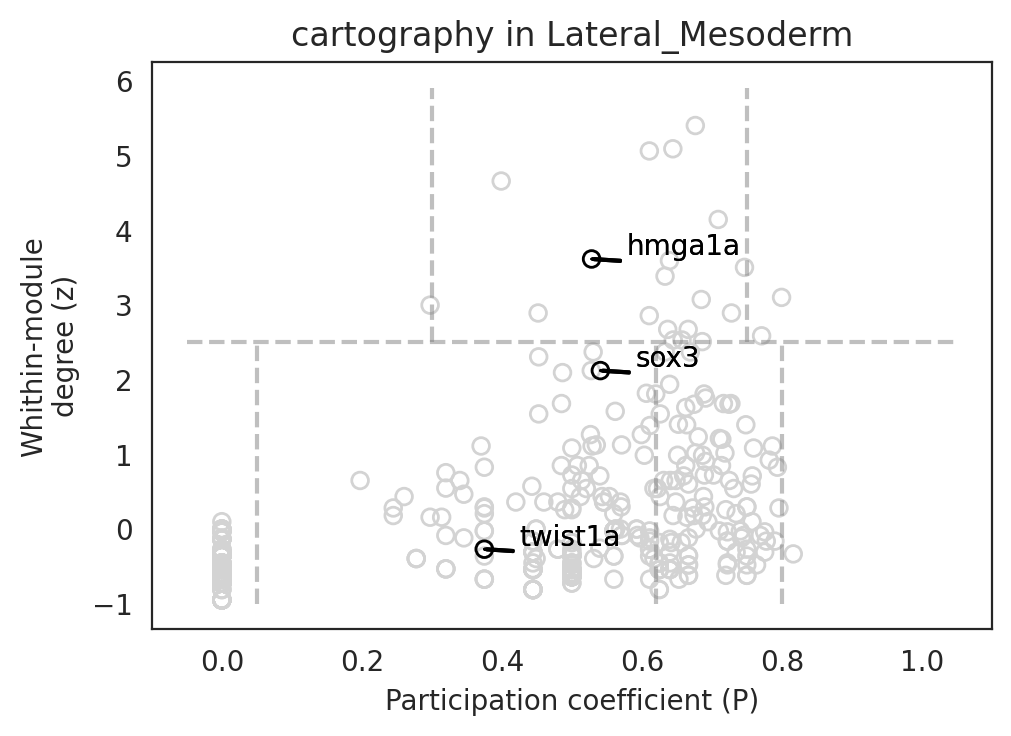

Muscle


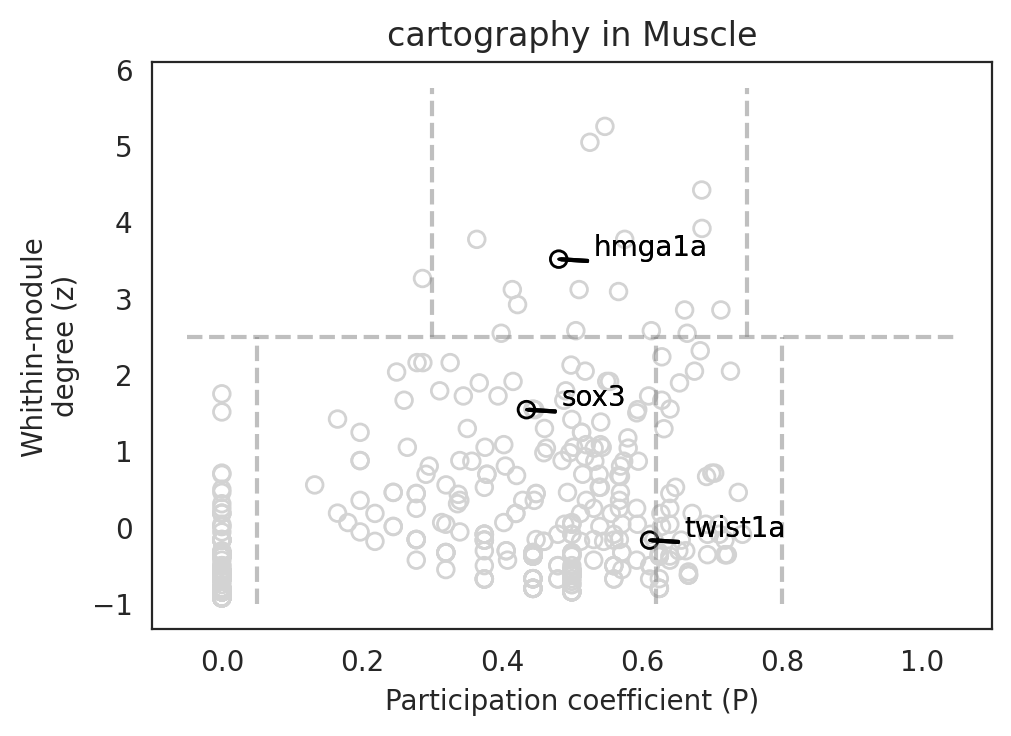

NMPs


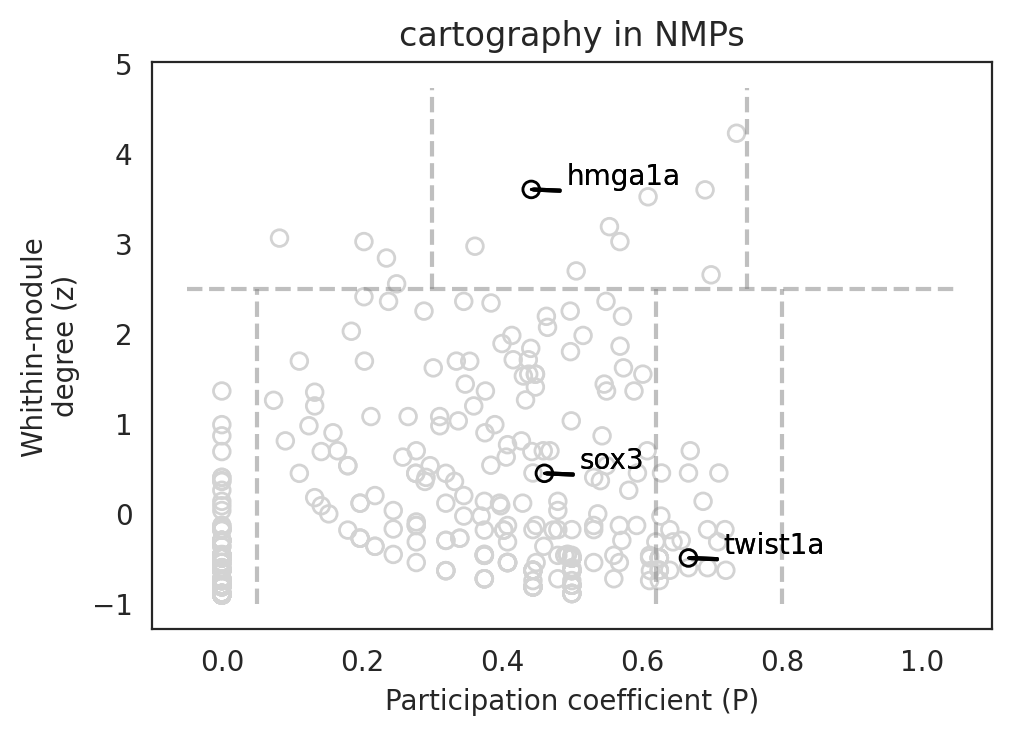

Neural_Anterior


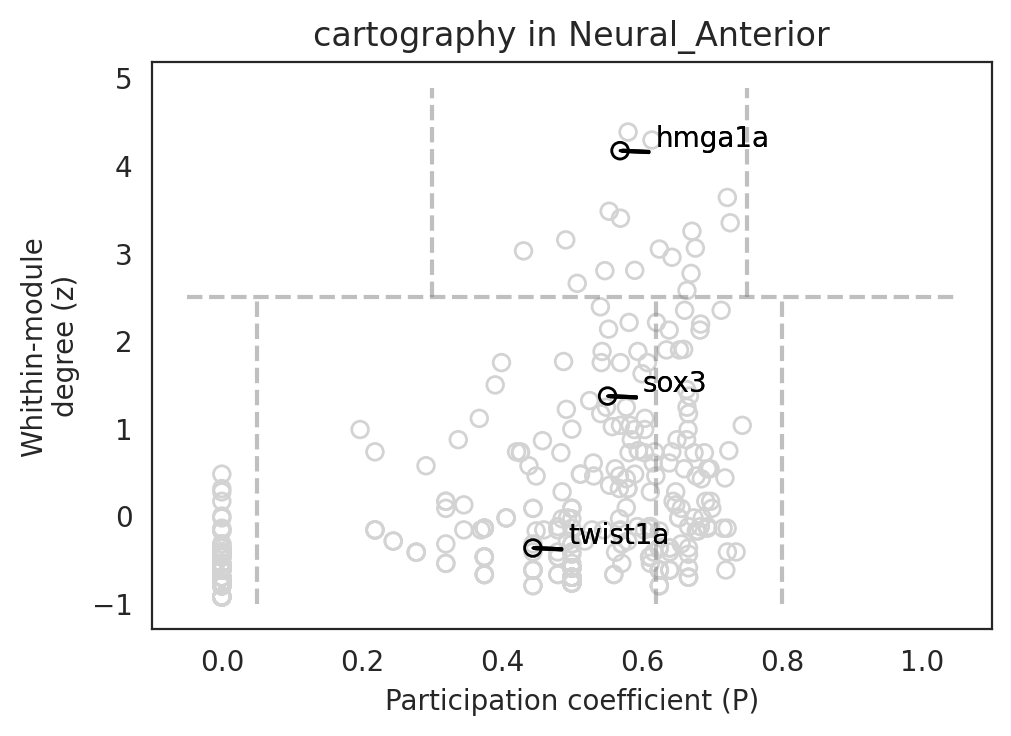

Neural_Crest


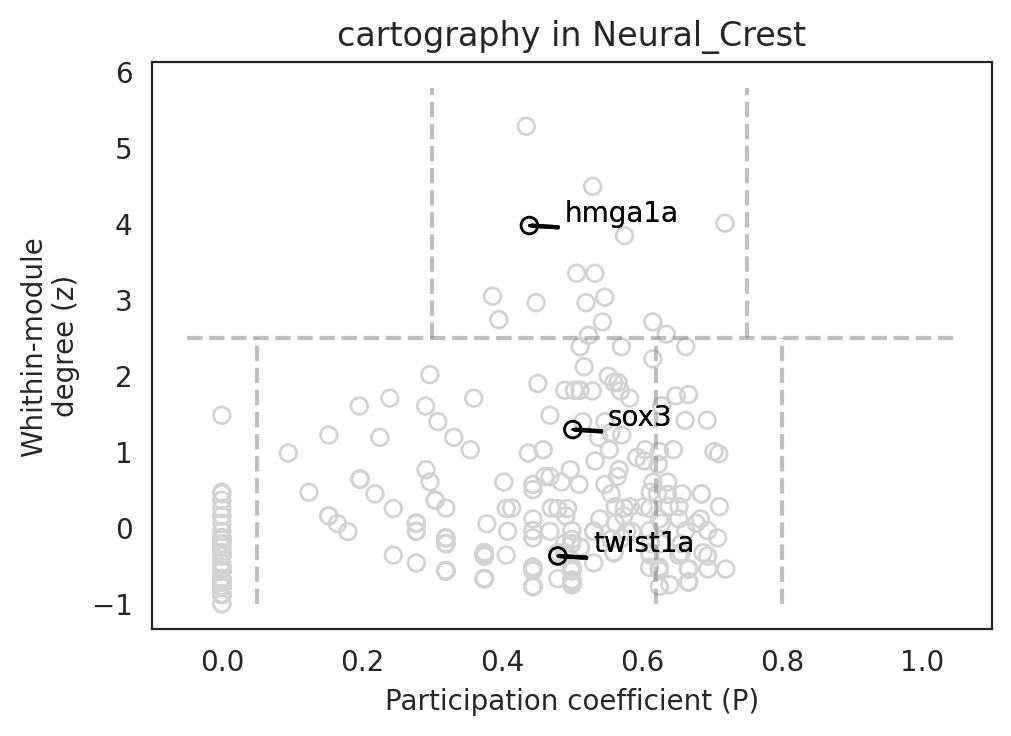

Neural_Posterior


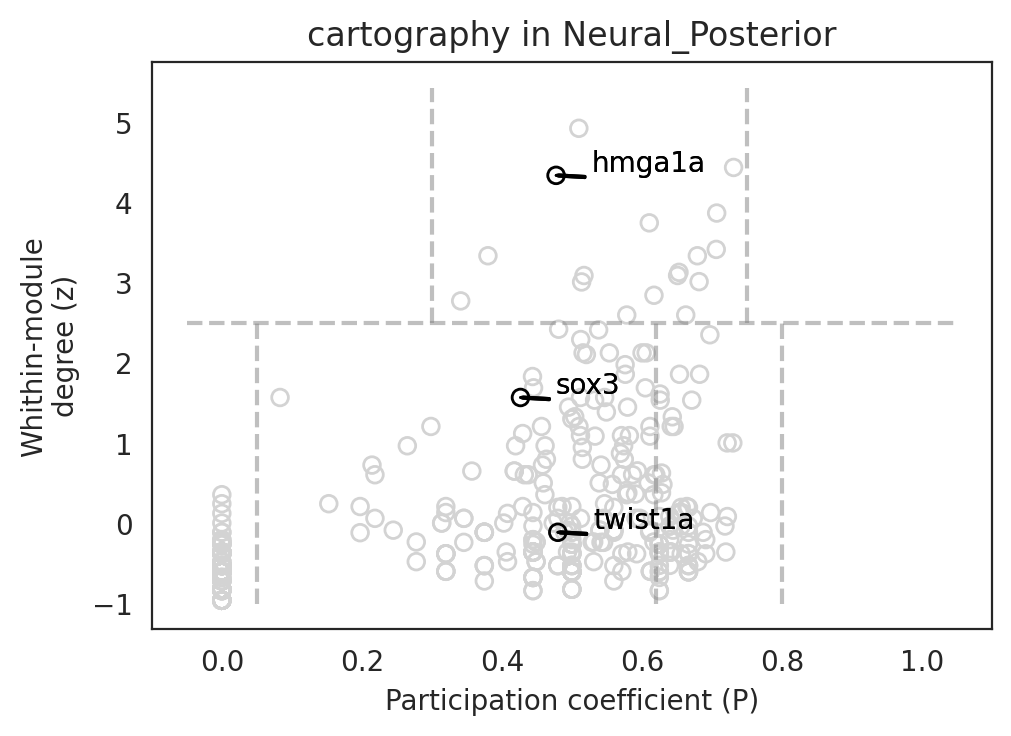

Notochord


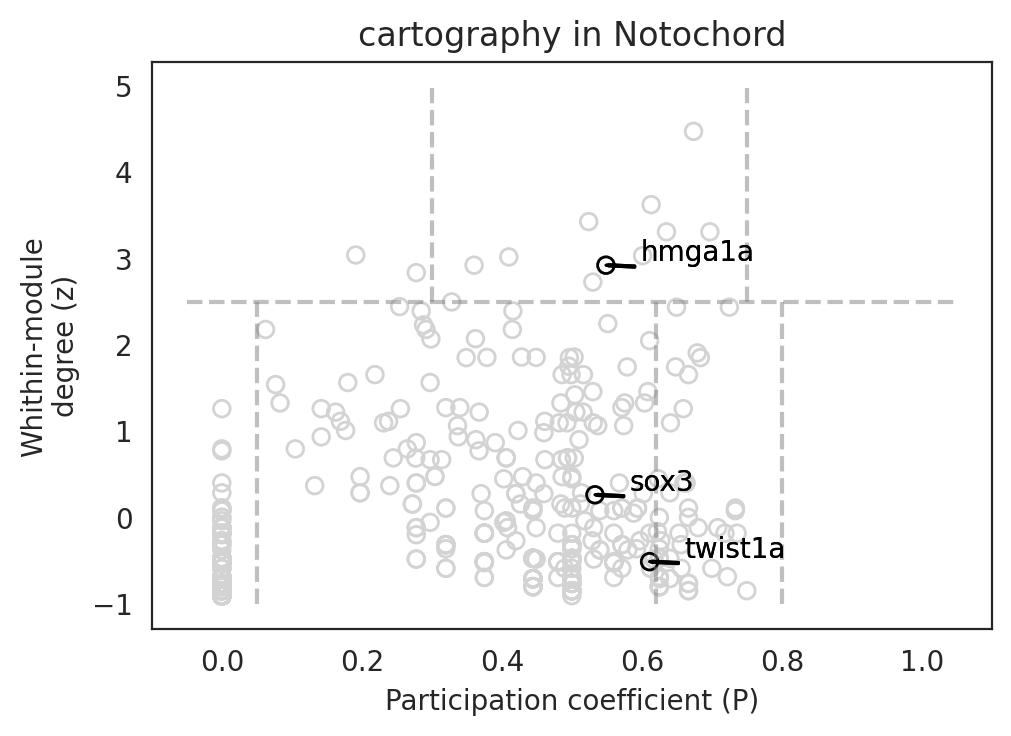

PSM


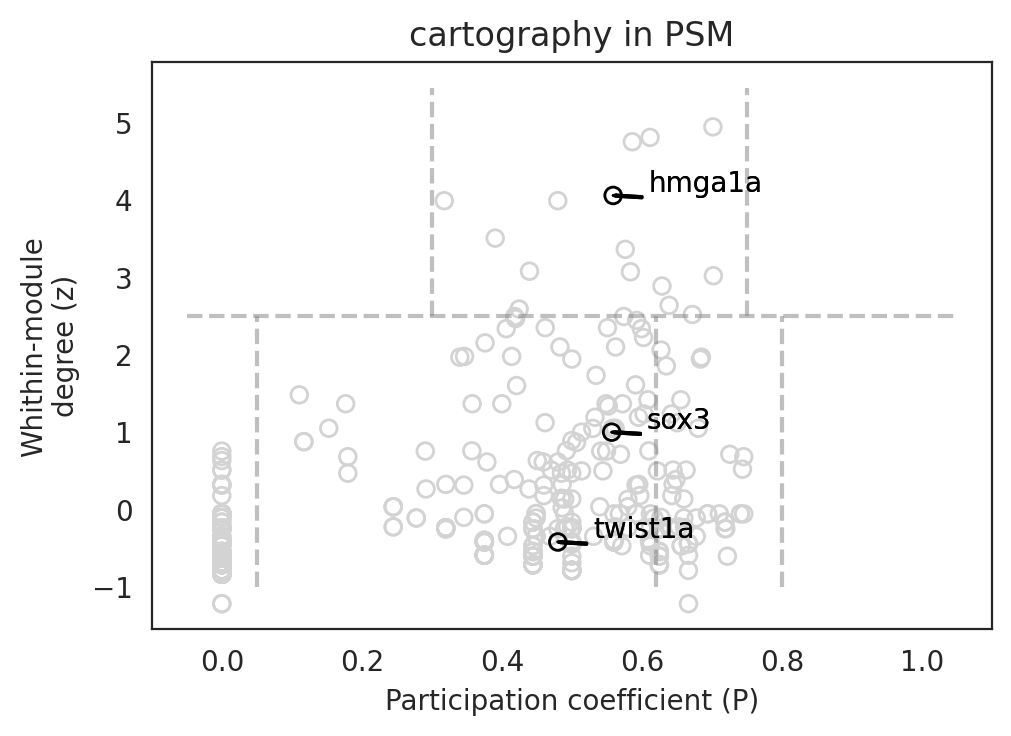

Somites


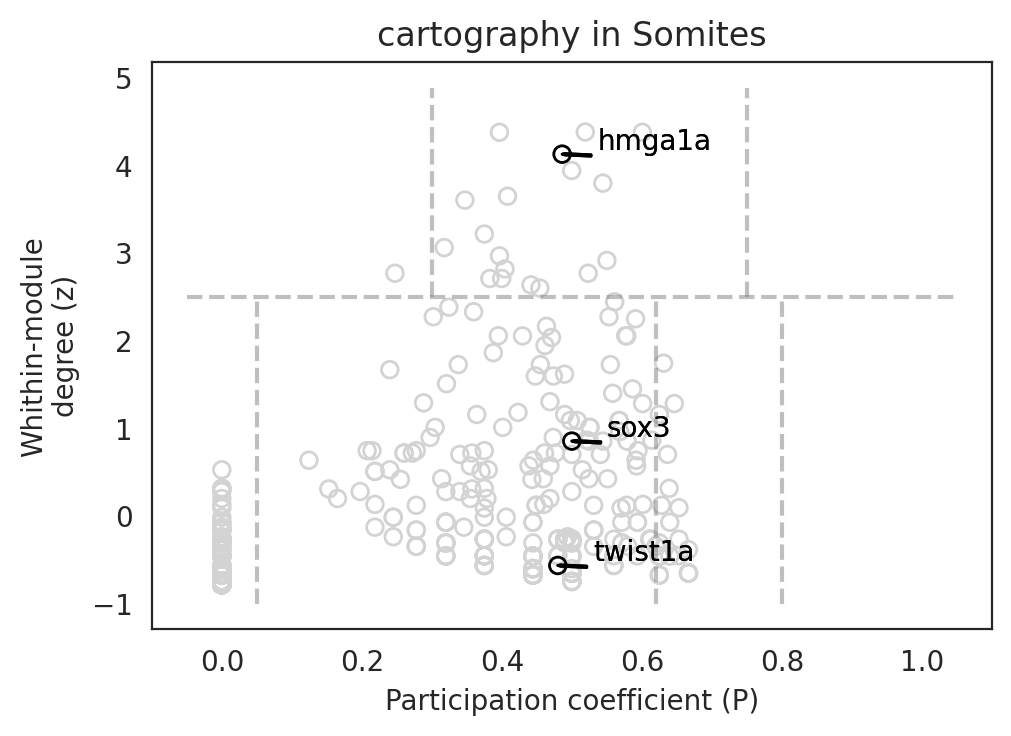

unassigned


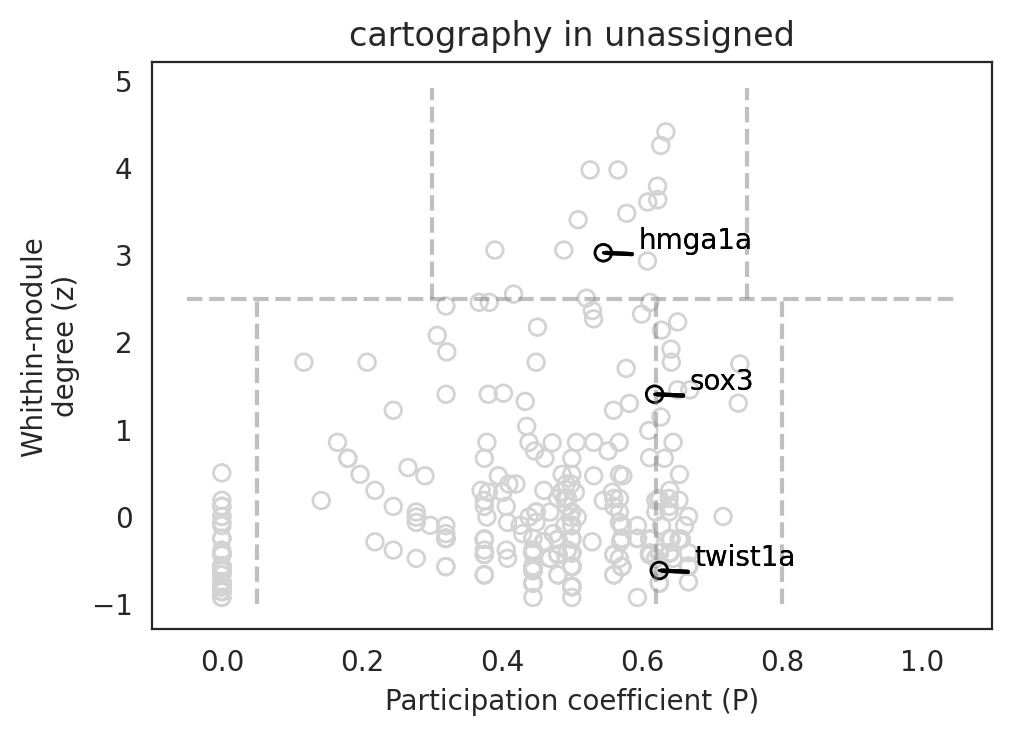

In [87]:
# Plot cartography as a scatter plot
links.plot_cartography_scatter_per_cluster(scatter=True,
                                           kde=False,
                                           gois=["hmga1a", "sox3", "twist1a"],
                                           auto_gene_annot=False,
                                           args_dot={"n_levels": 105},
                                           args_line={"c":"gray"}) #, save="TDR118_15somite_GRN_coarse_celltypes/cartography")

In [90]:
output_filepath

'/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/'

In [92]:
# # Plot the summary of cartography analysis
# links.plot_cartography_term(goi="sox3", save= output_filepath + "figures_danRer11/cartography")

# 8. Network analysis; network score distribution

Next, we visualize the distribution of network score to get insight into the global trend of the GRNs.

## 8.1. Distribution of network degree

degree_centrality_all


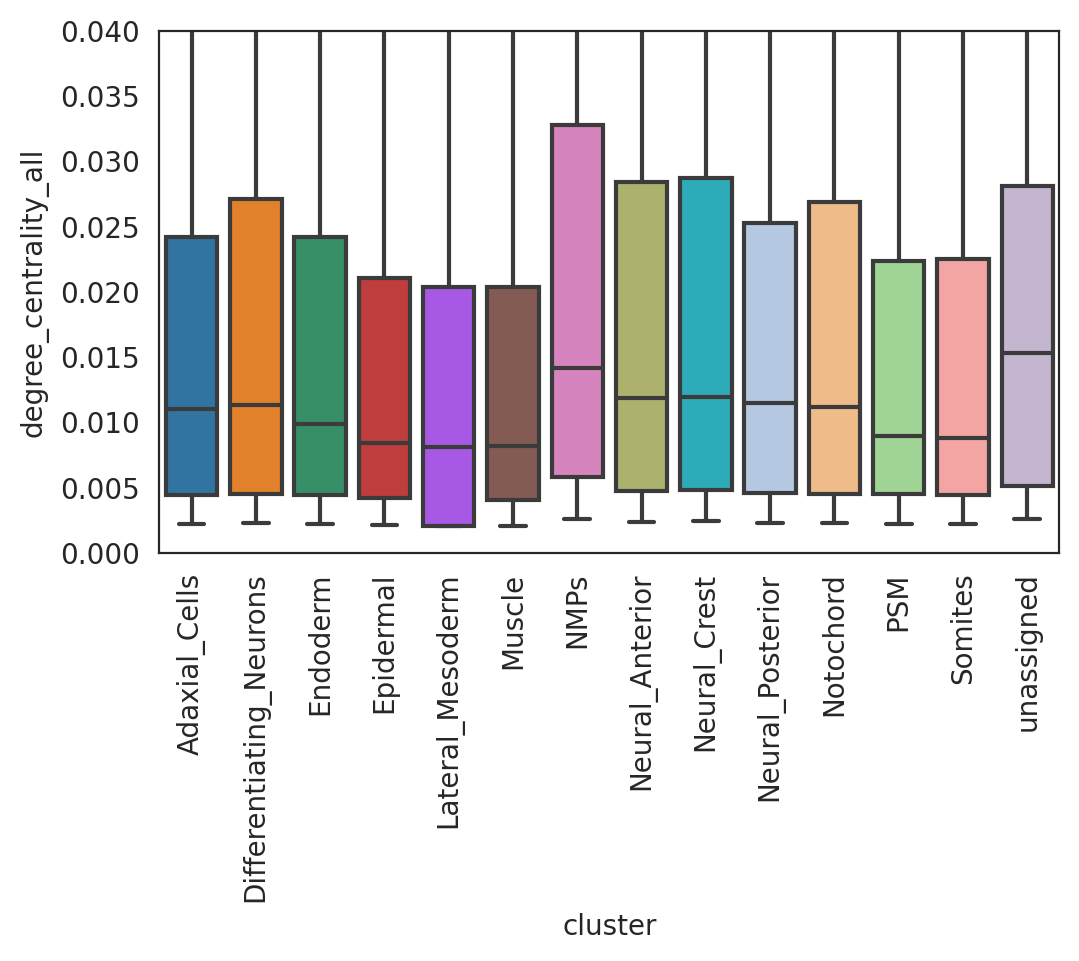

In [93]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.040])
links.plot_score_discributions(values=["degree_centrality_all"], method="boxplot")#, save="TDR118_15somite_GRN_coarse_celltypes")



eigenvector_centrality


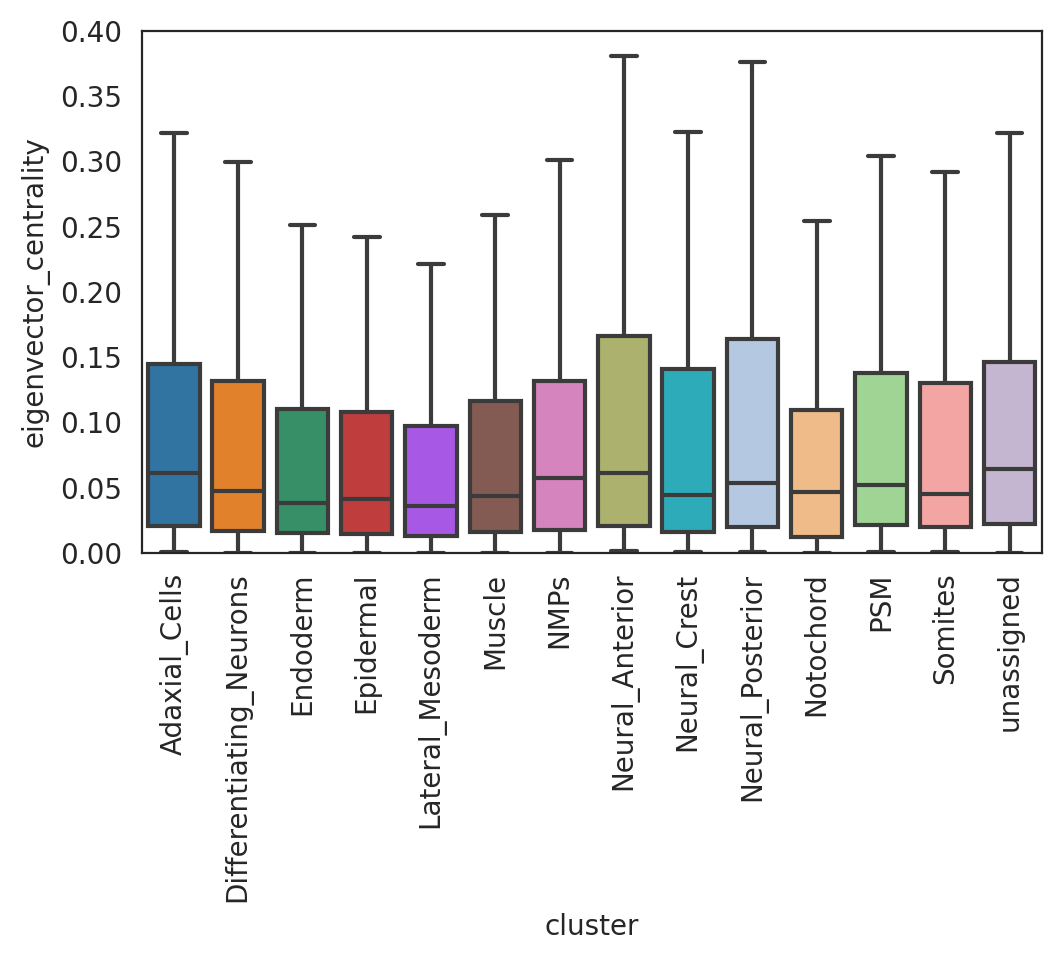

In [94]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 0.40])
links.plot_score_discributions(values=["eigenvector_centrality"], method="boxplot")# , save="TDR118_15somite_GRN_coarse_celltypes")




## 8.2. Distribution of netowrk entropy

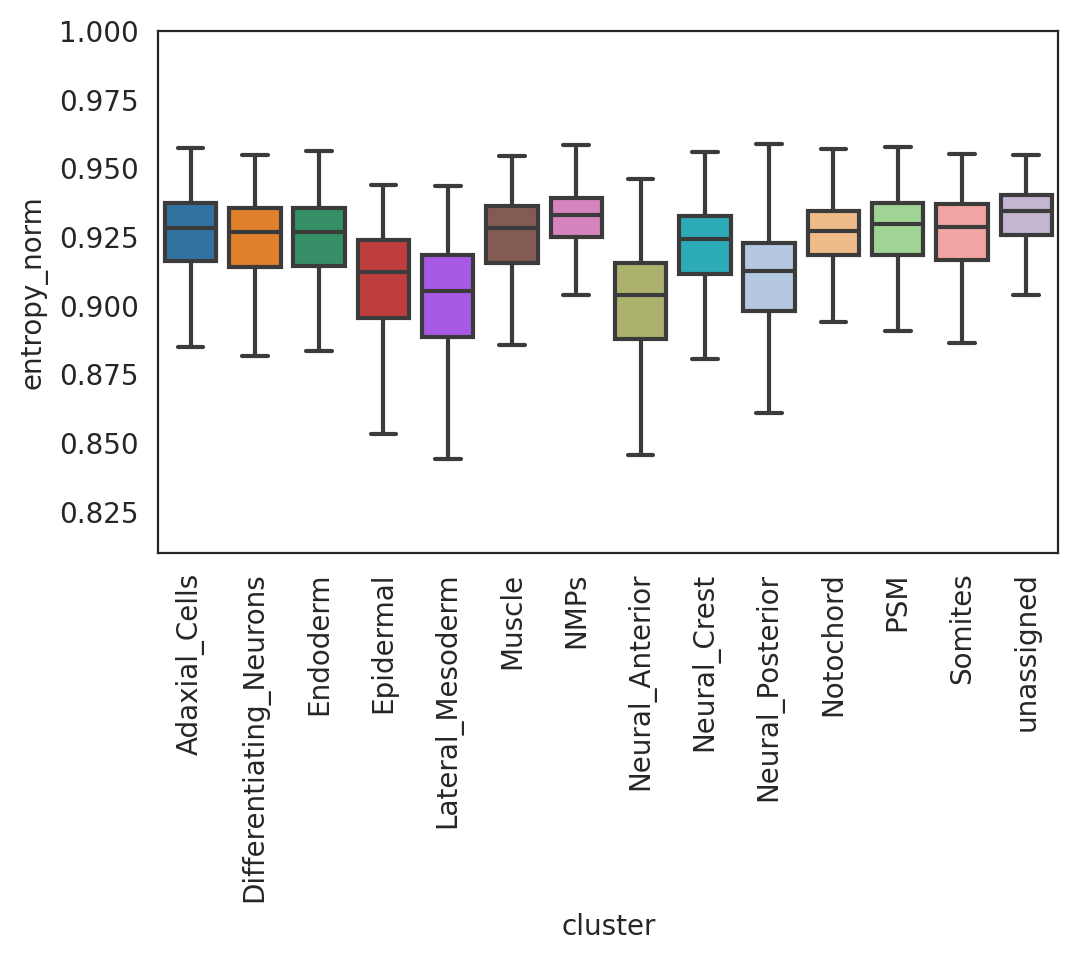

In [95]:
plt.subplots_adjust(left=0.15, bottom=0.3)
links.plot_network_entropy_distributions() #(save="TDR118_15somite_GRN_coarse_celltypes")



Using the network scores, we could pick up cluster-specific key TFs.
Gata2, Gata1, Klf1, E2f1, for example, are known to play an essential role in MEP, and these TFs showed high network score in our GRN.

However, it is important to note that network analysis alone cannot shed light on the specific functions or roles these TFs play in cell fate determination. 

In the next section, we will begin to investigate each TF’s contribution to cell fate by running GRN simulations